In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pylab as plt
from scipy.integrate import odeint as scipy_odeint

# size of training set
size = 10000
# time domain for the sine wave
t = np.linspace(0, 25, size)
# initial condition
true_y0 = [0., 1.]
# analytical ODE system for sine wave [x, t] -> [v, a]
ode_func = lambda y, t: [np.cos(t), -np.sin(t)]
# numerically integrate the analytical ODE system for sine wave
true_y = scipy_odeint(ode_func, true_y0, t)

In [5]:
true_y

array([[ 0.        ,  1.        ],
       [ 0.00250025,  0.99999687],
       [ 0.00500048,  0.9999875 ],
       ...,
       [-0.13730658,  0.99052863],
       [-0.13482958,  0.99086884],
       [-0.13235174,  0.99120285]])

Iteration: 100 | Total Loss 0.003578


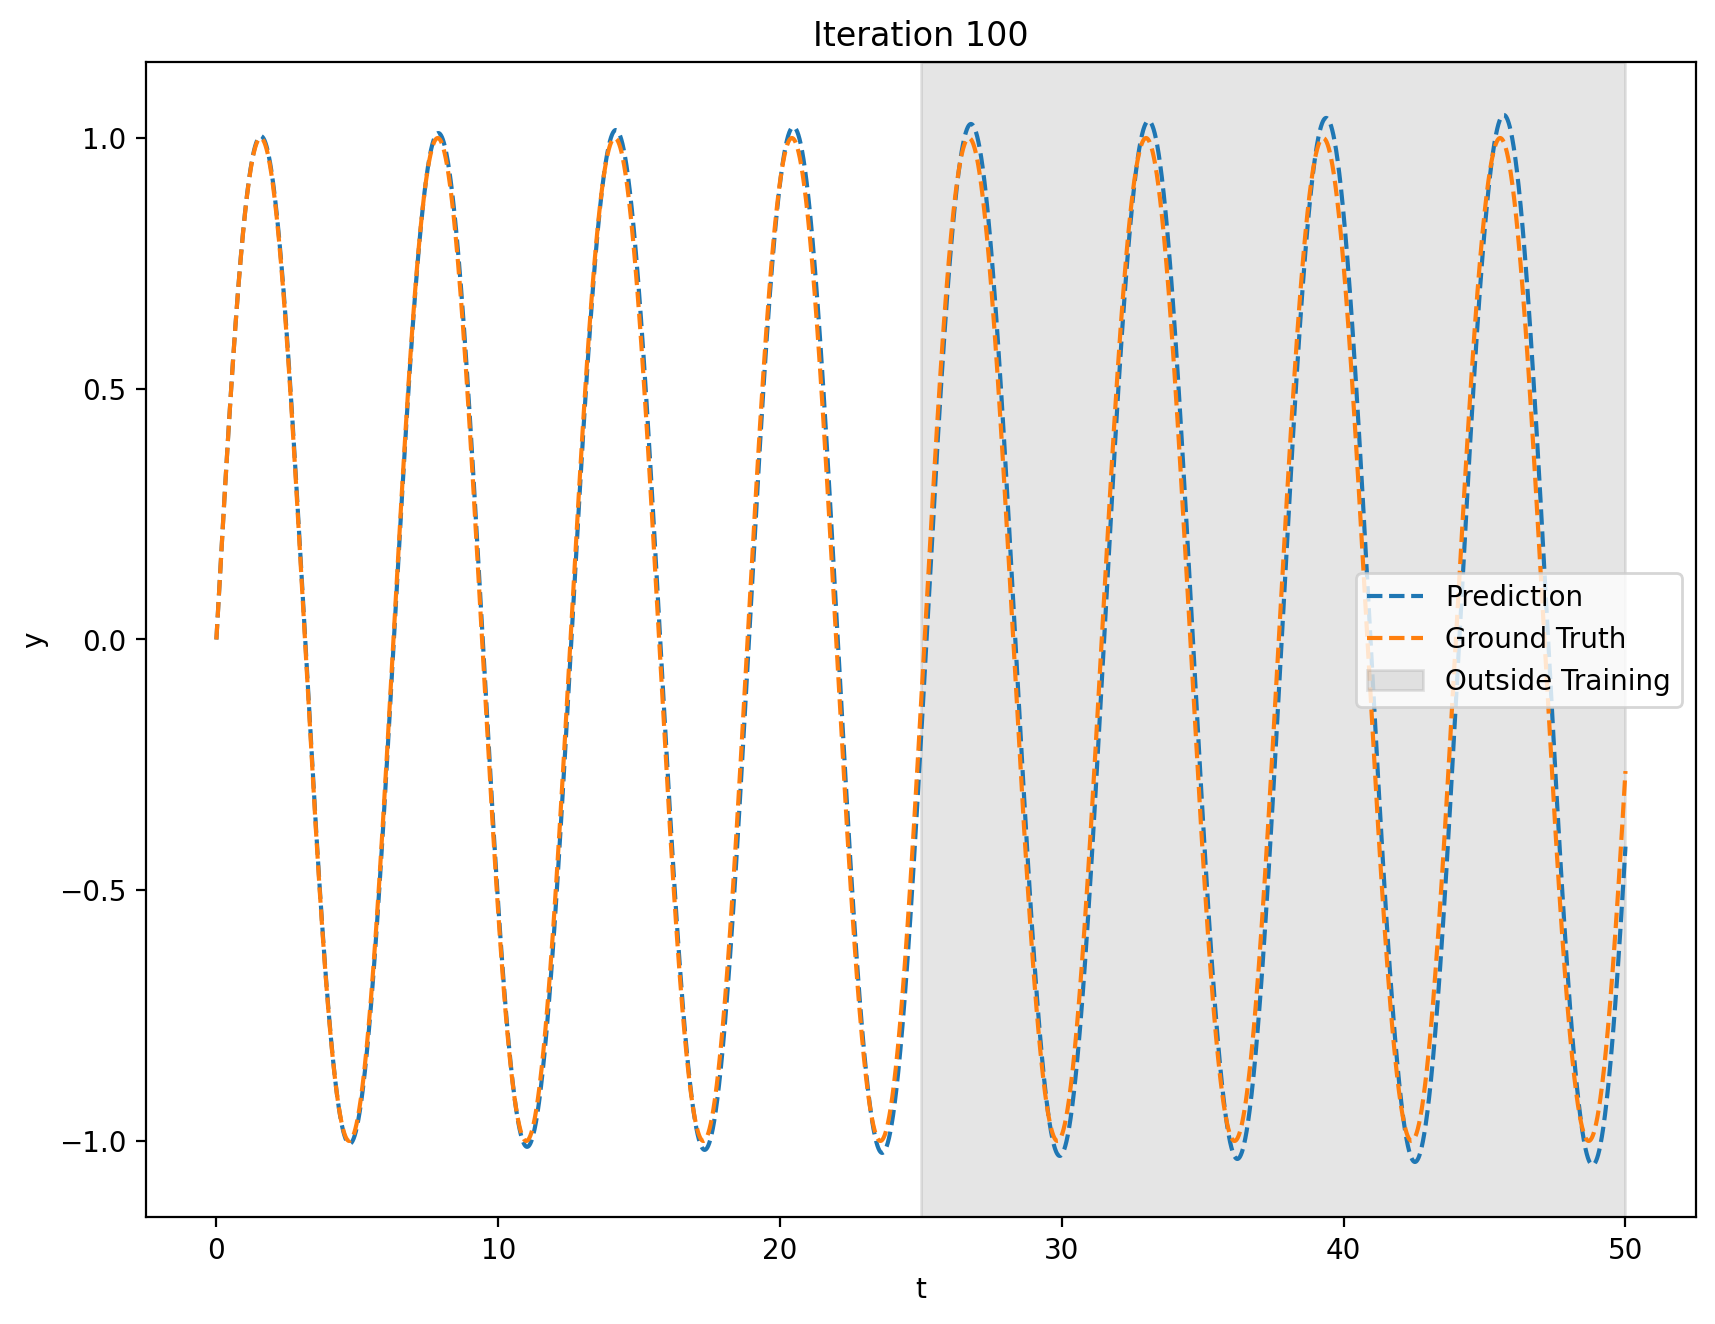

Iteration: 200 | Total Loss 0.000001


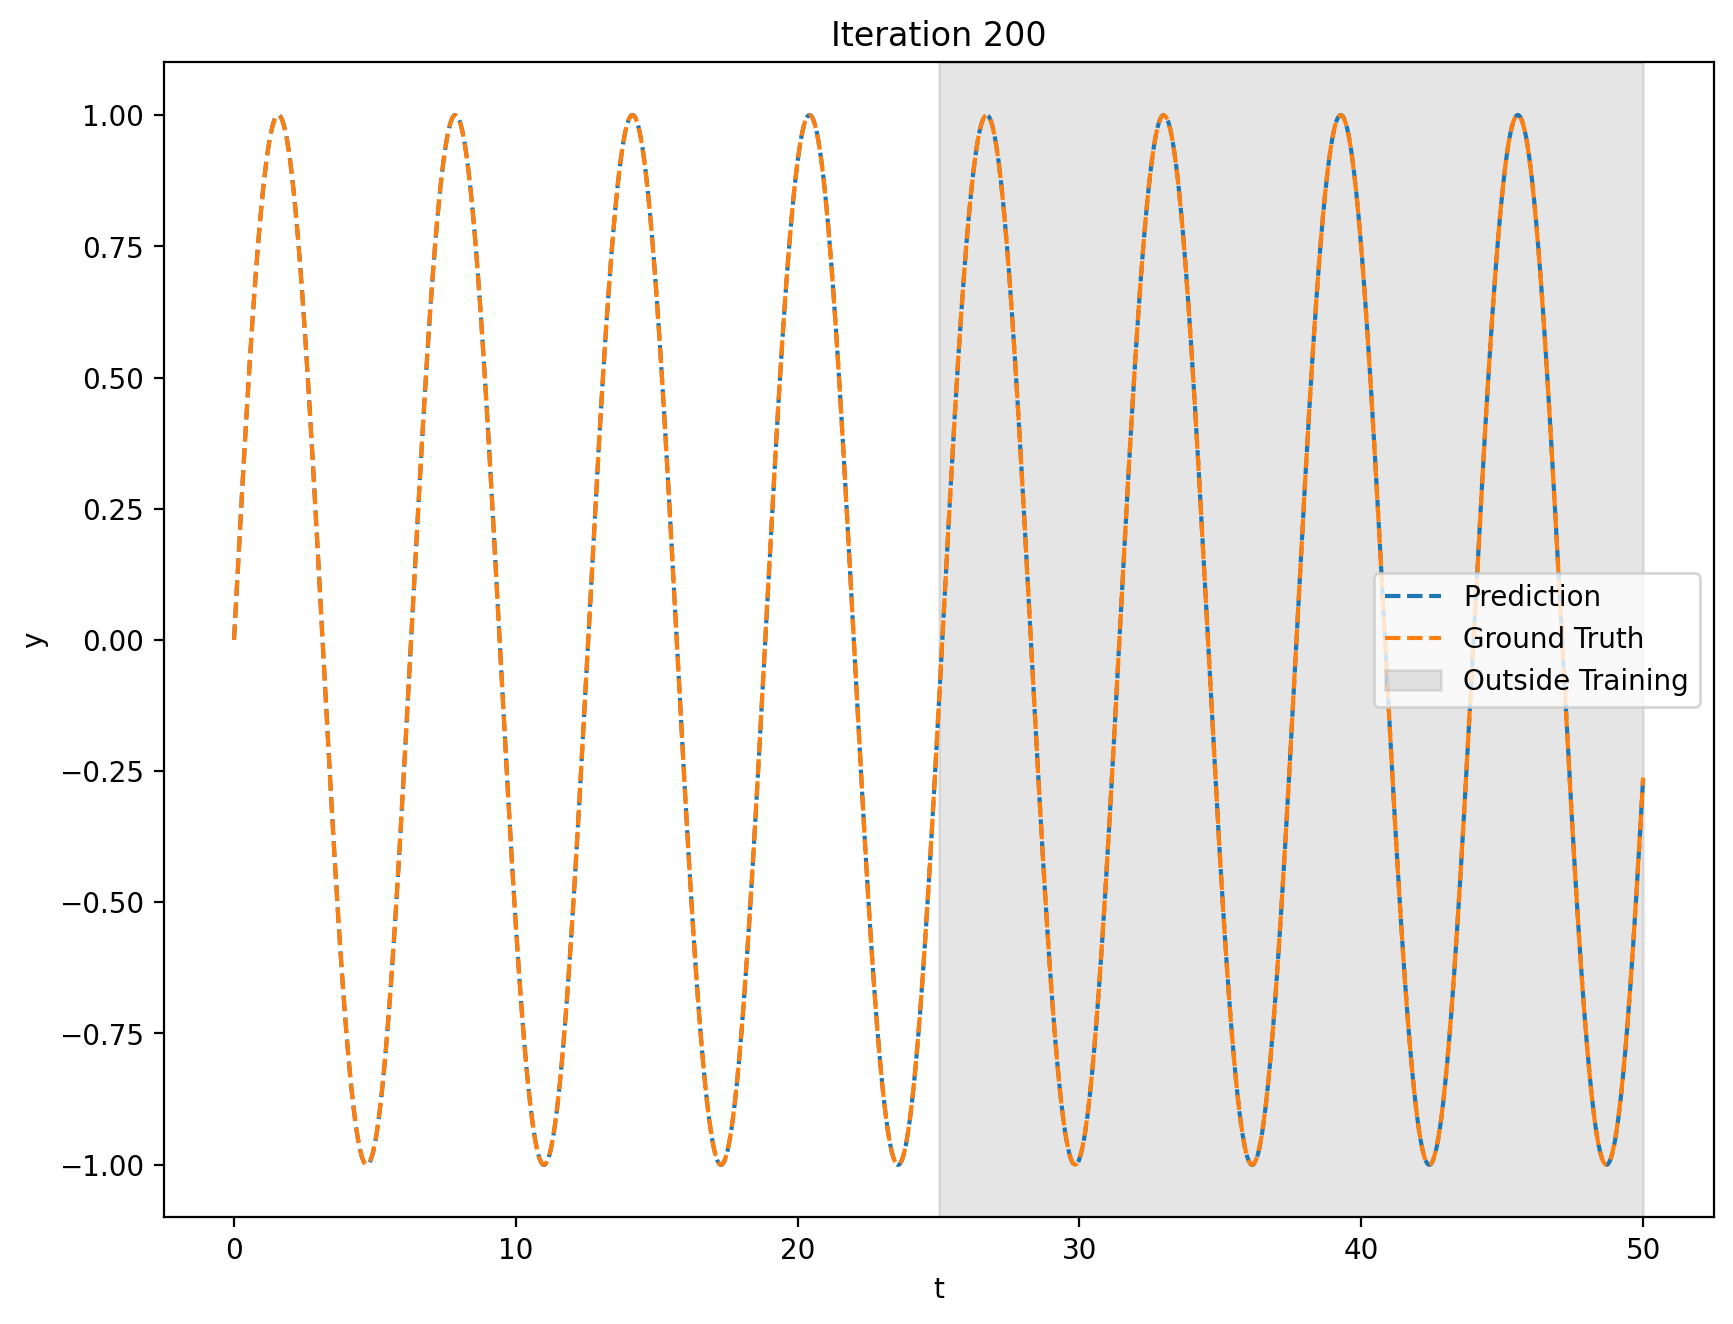

Iteration: 300 | Total Loss 0.000001


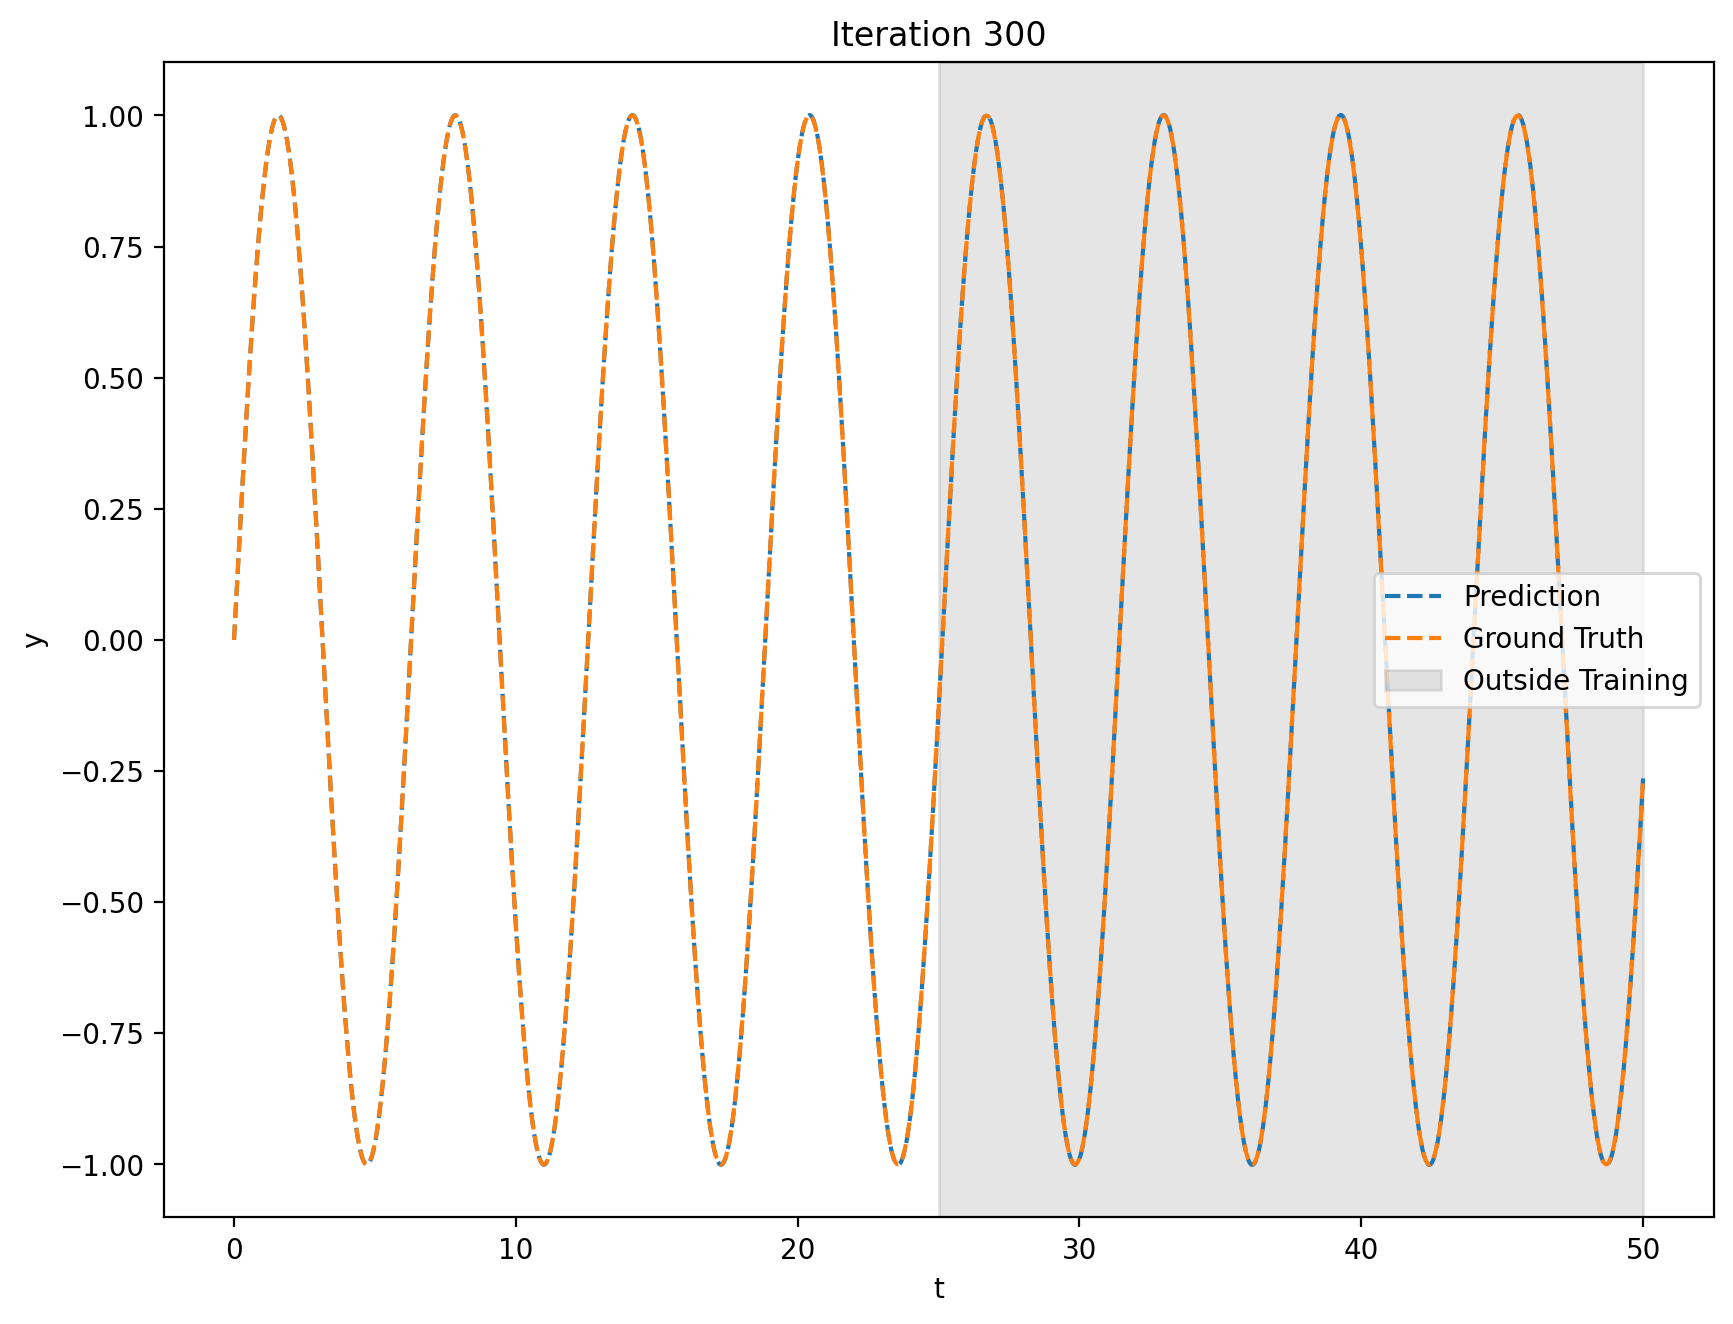

Iteration: 400 | Total Loss 0.000001


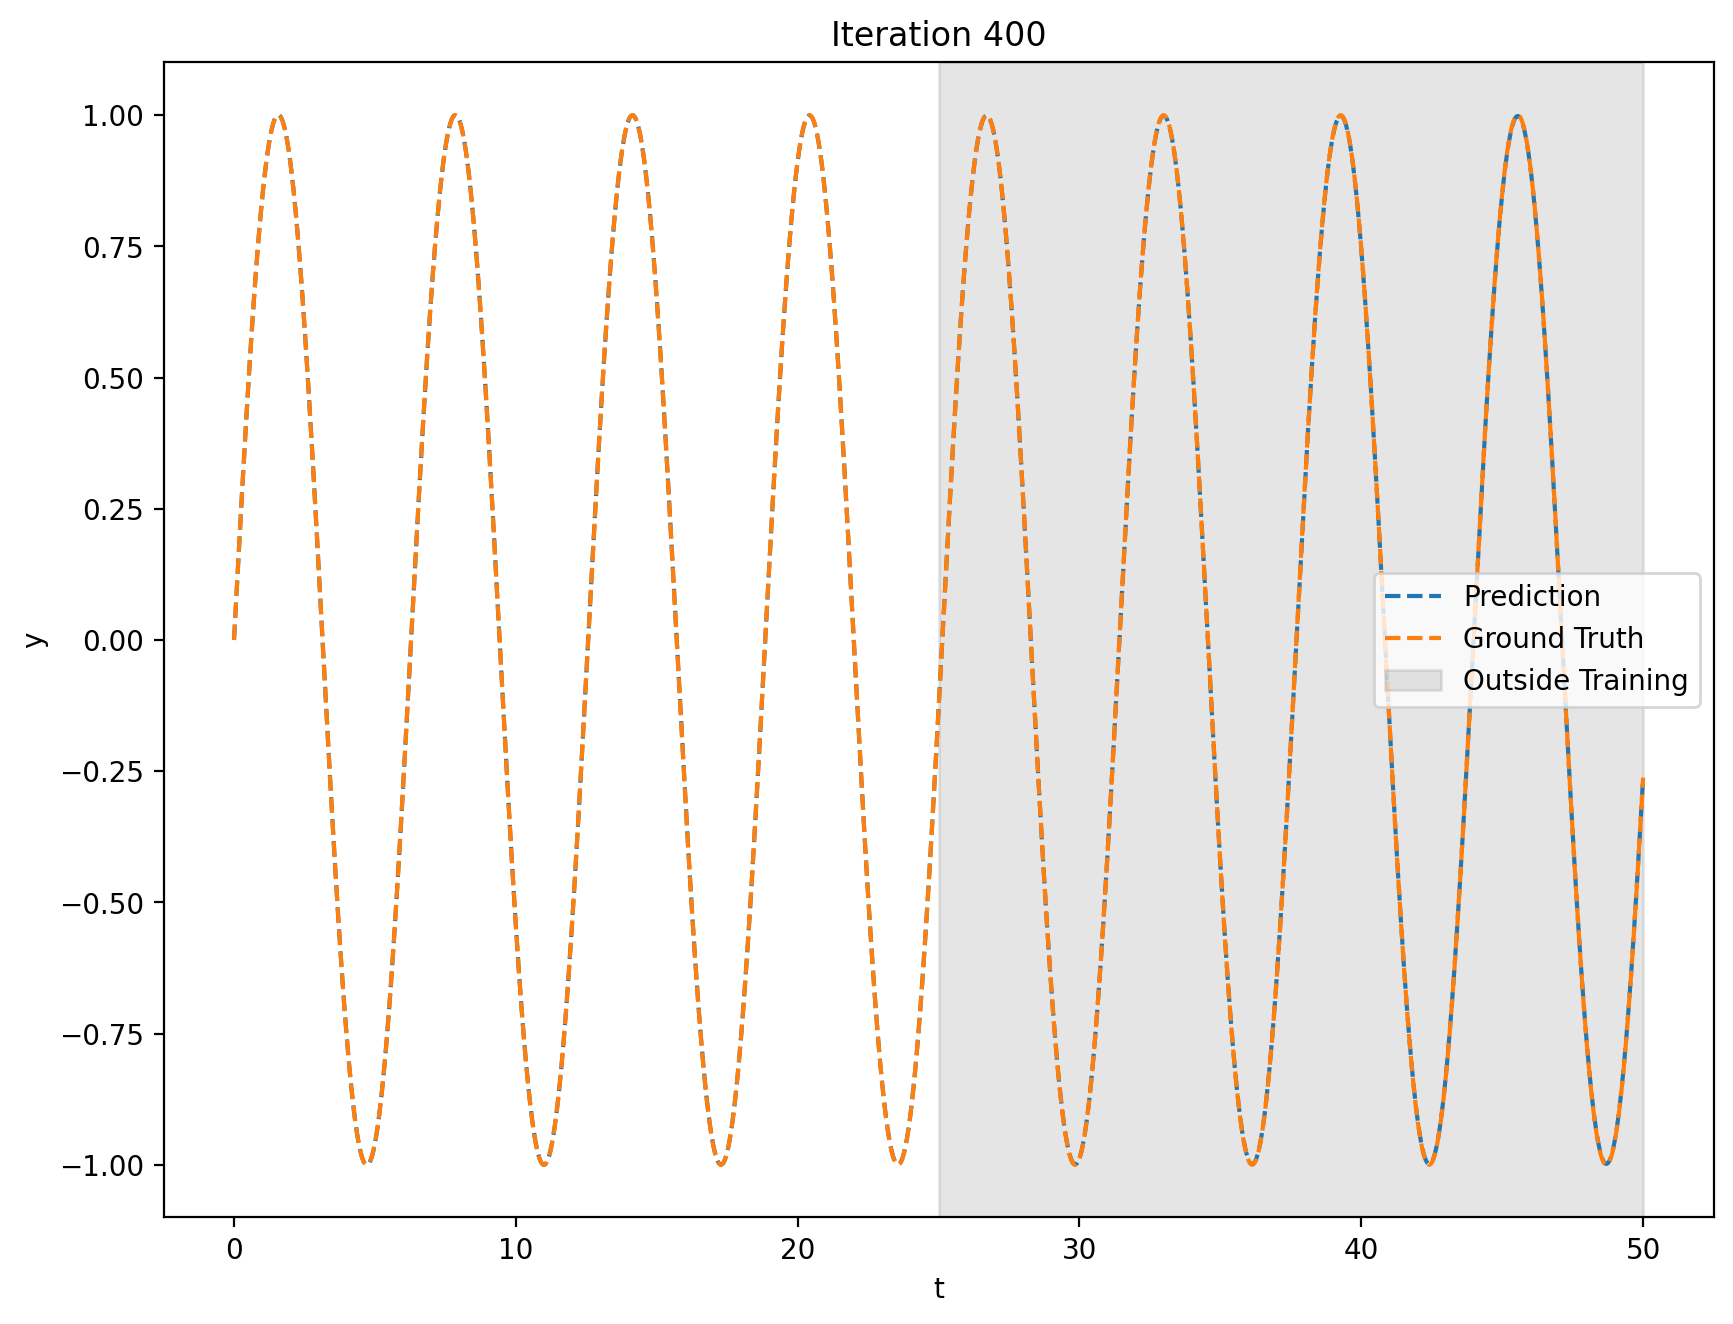

Iteration: 500 | Total Loss 0.000002


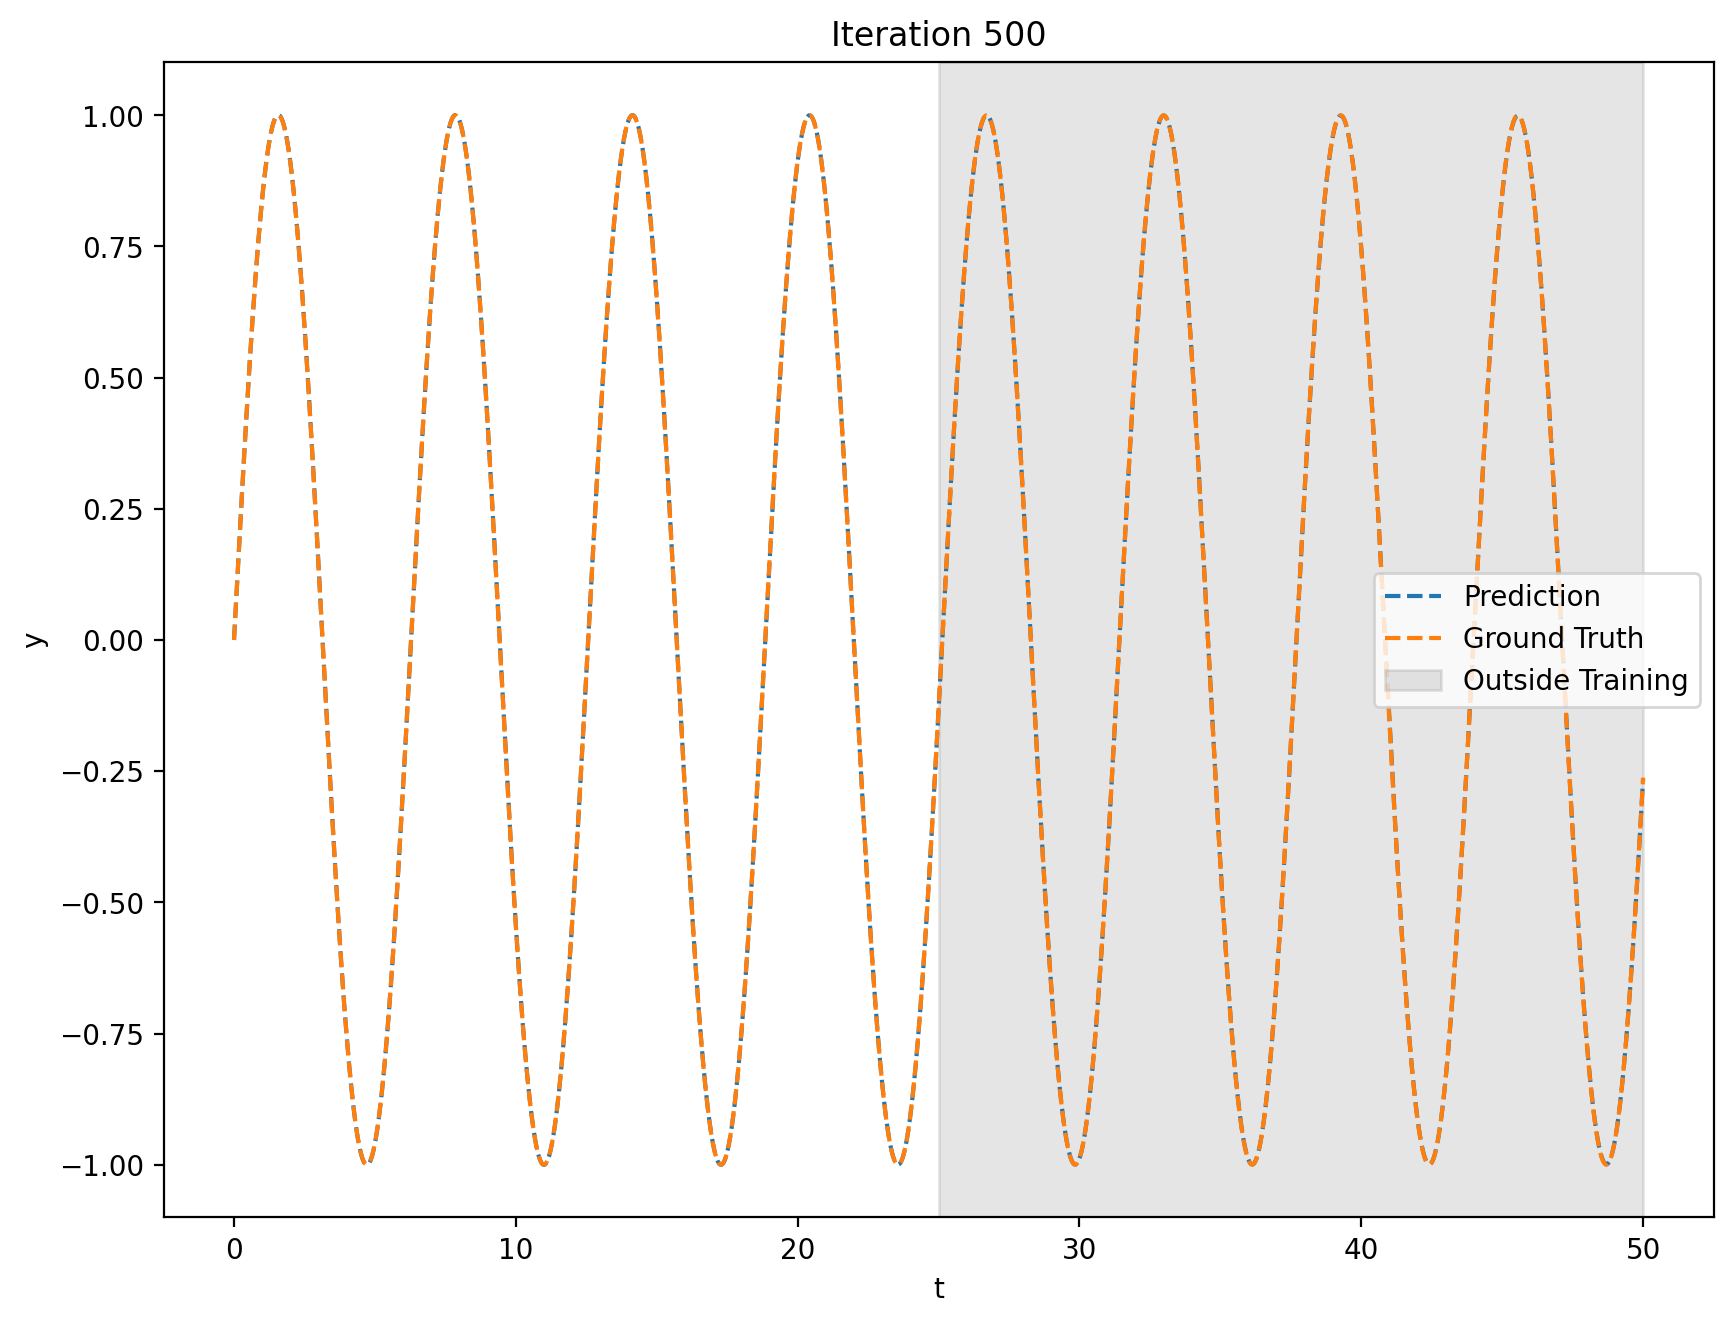

Iteration: 600 | Total Loss 0.000003


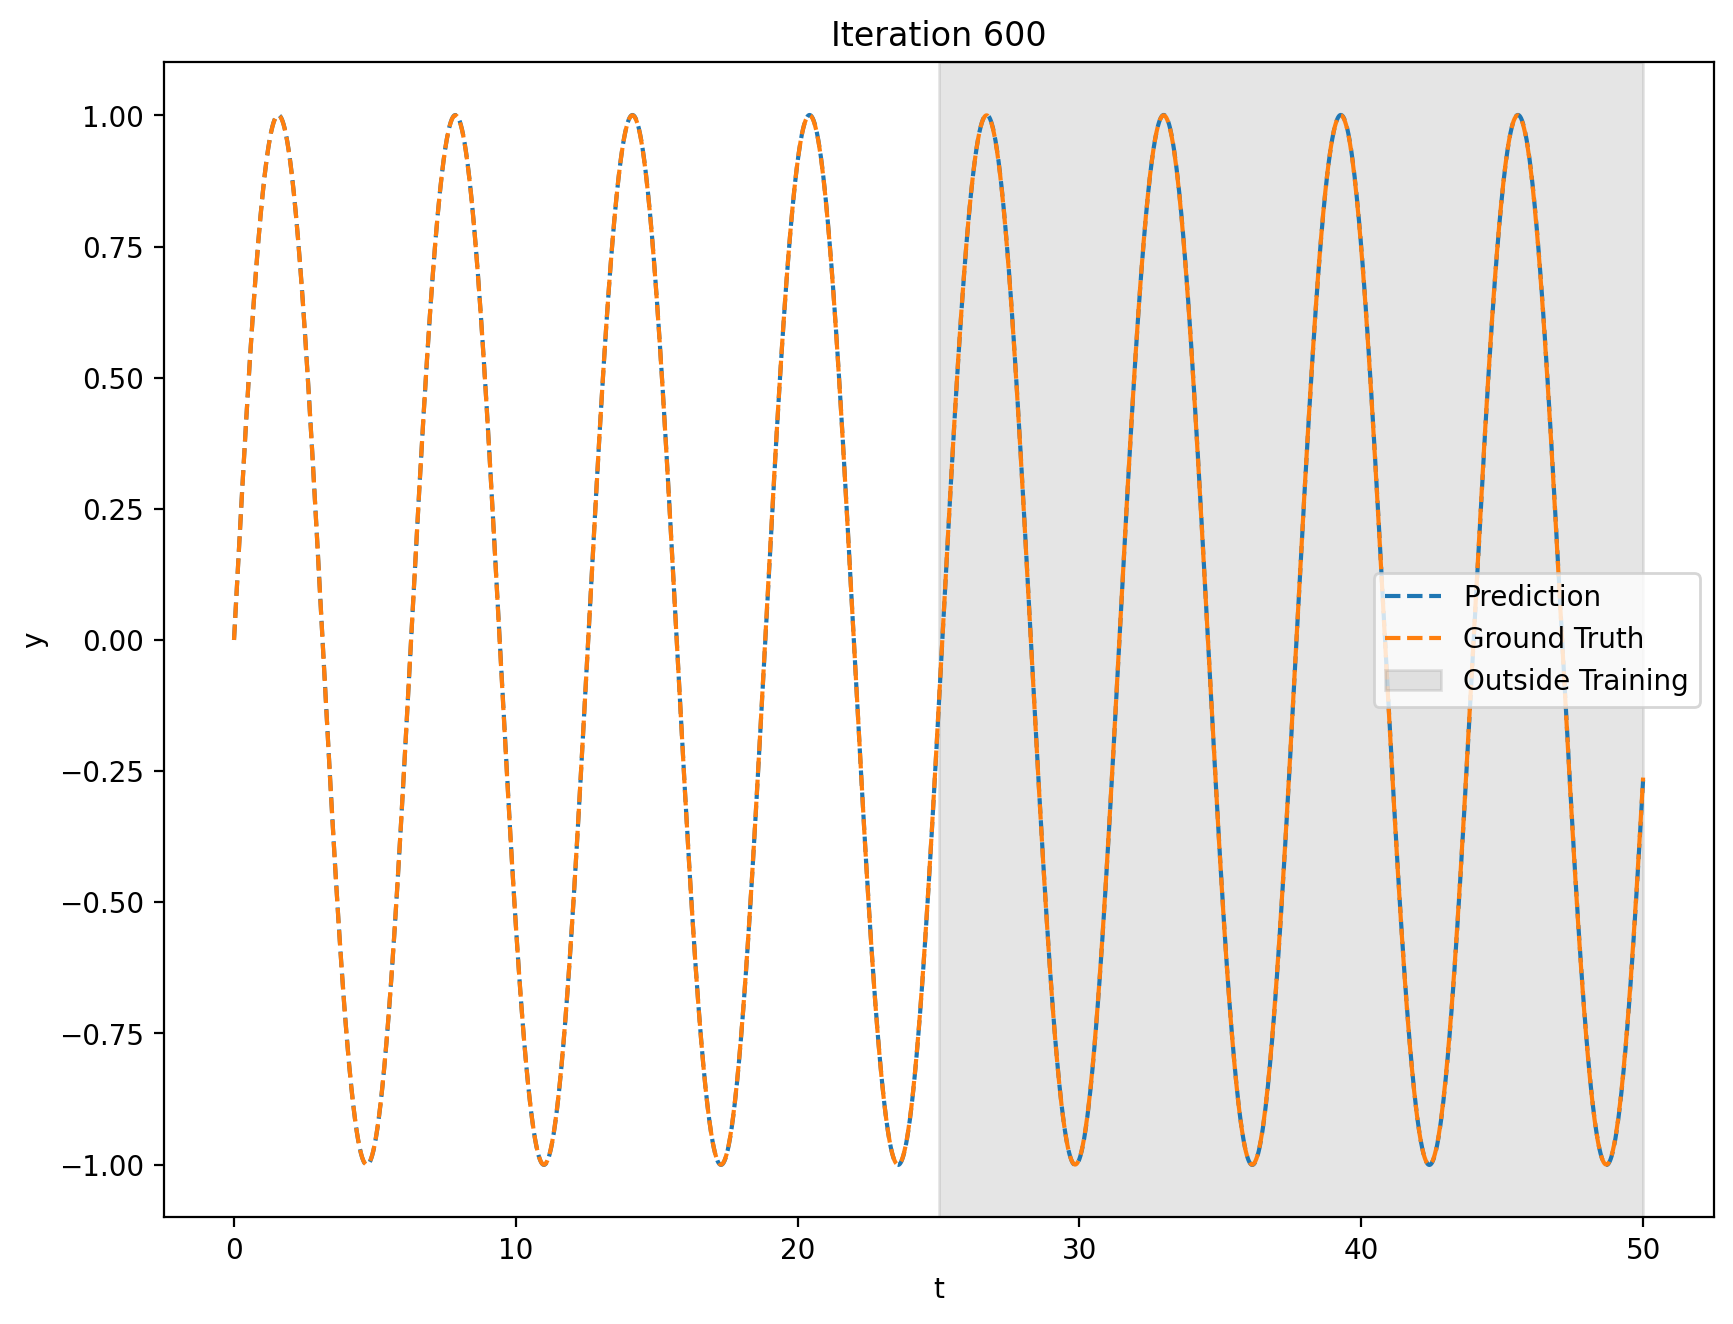

Iteration: 700 | Total Loss 0.000003


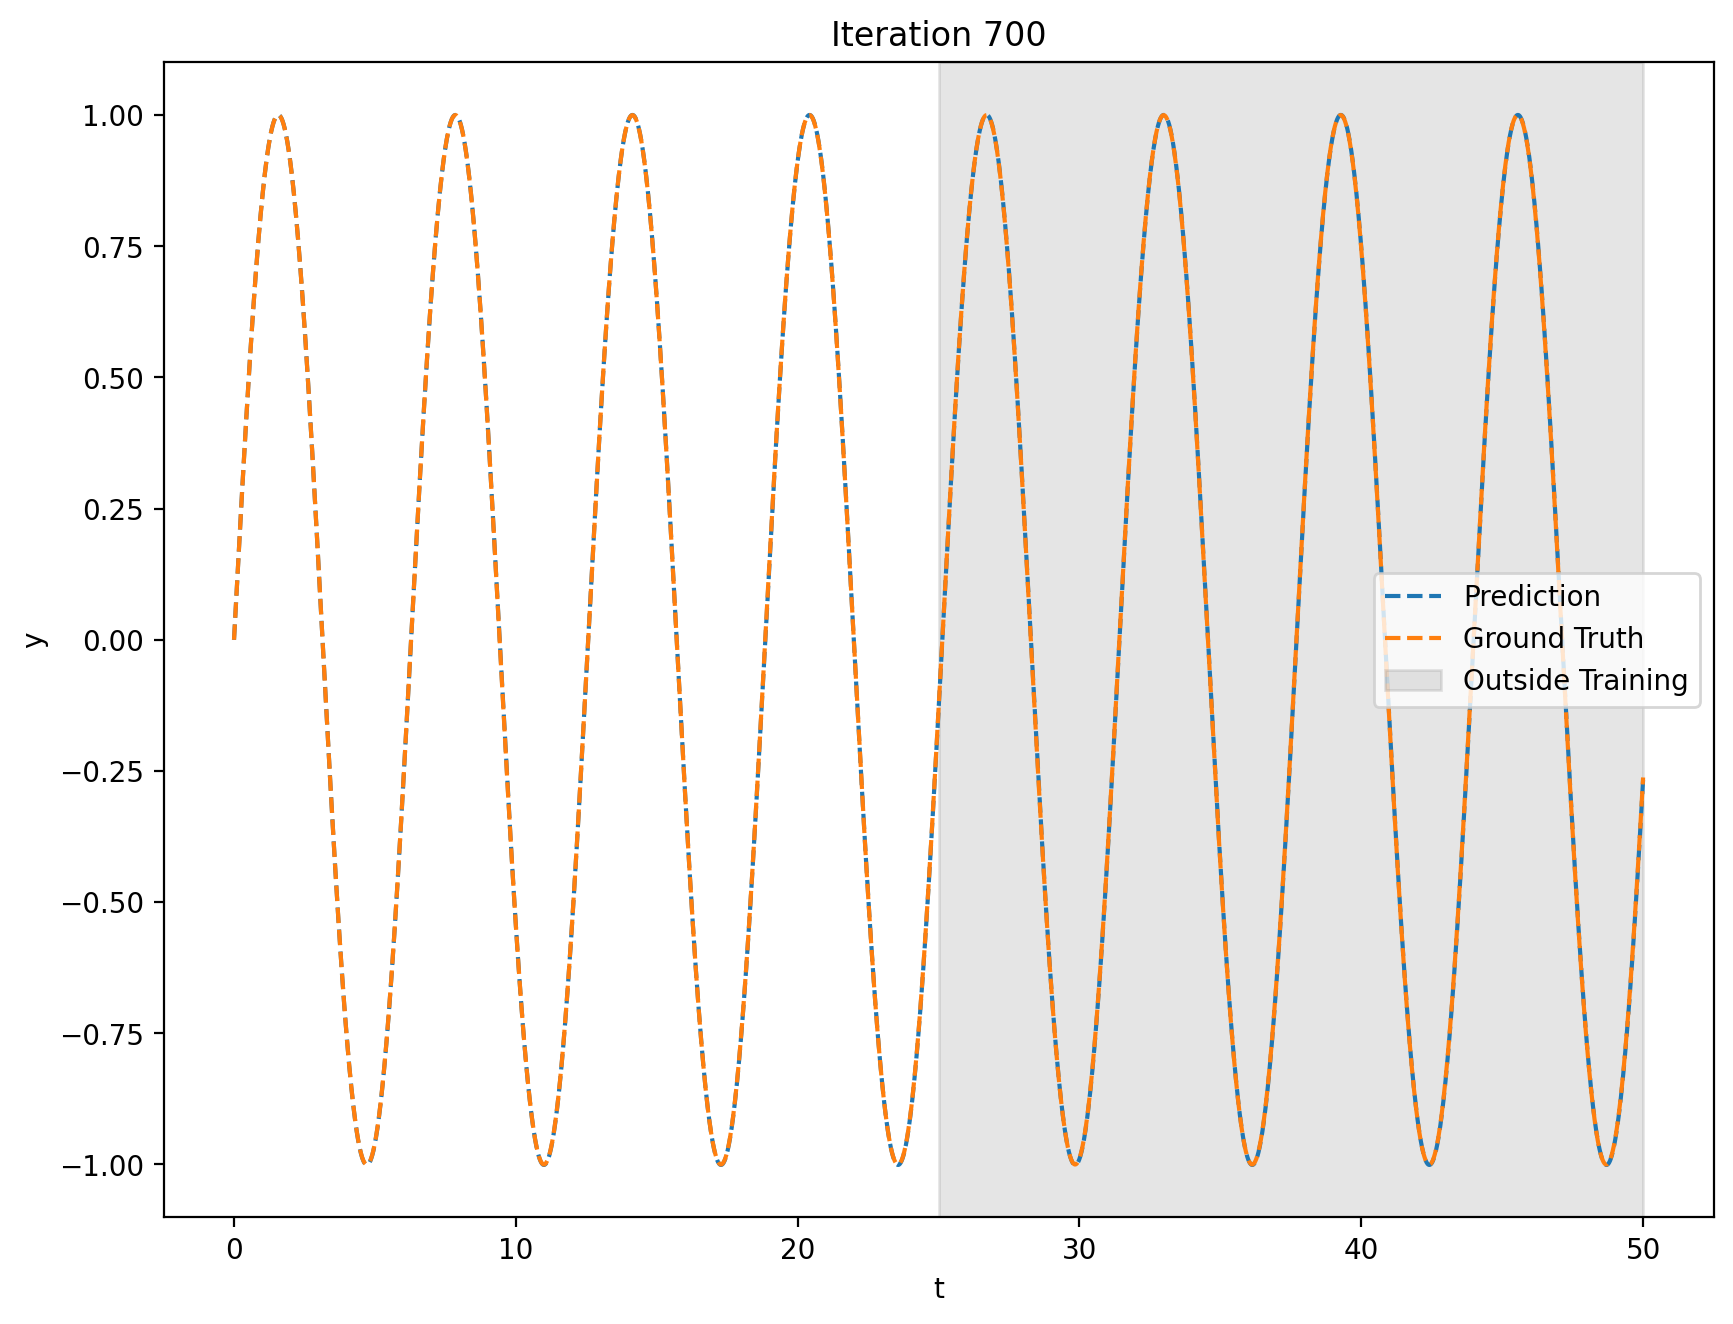

Iteration: 800 | Total Loss 0.000002


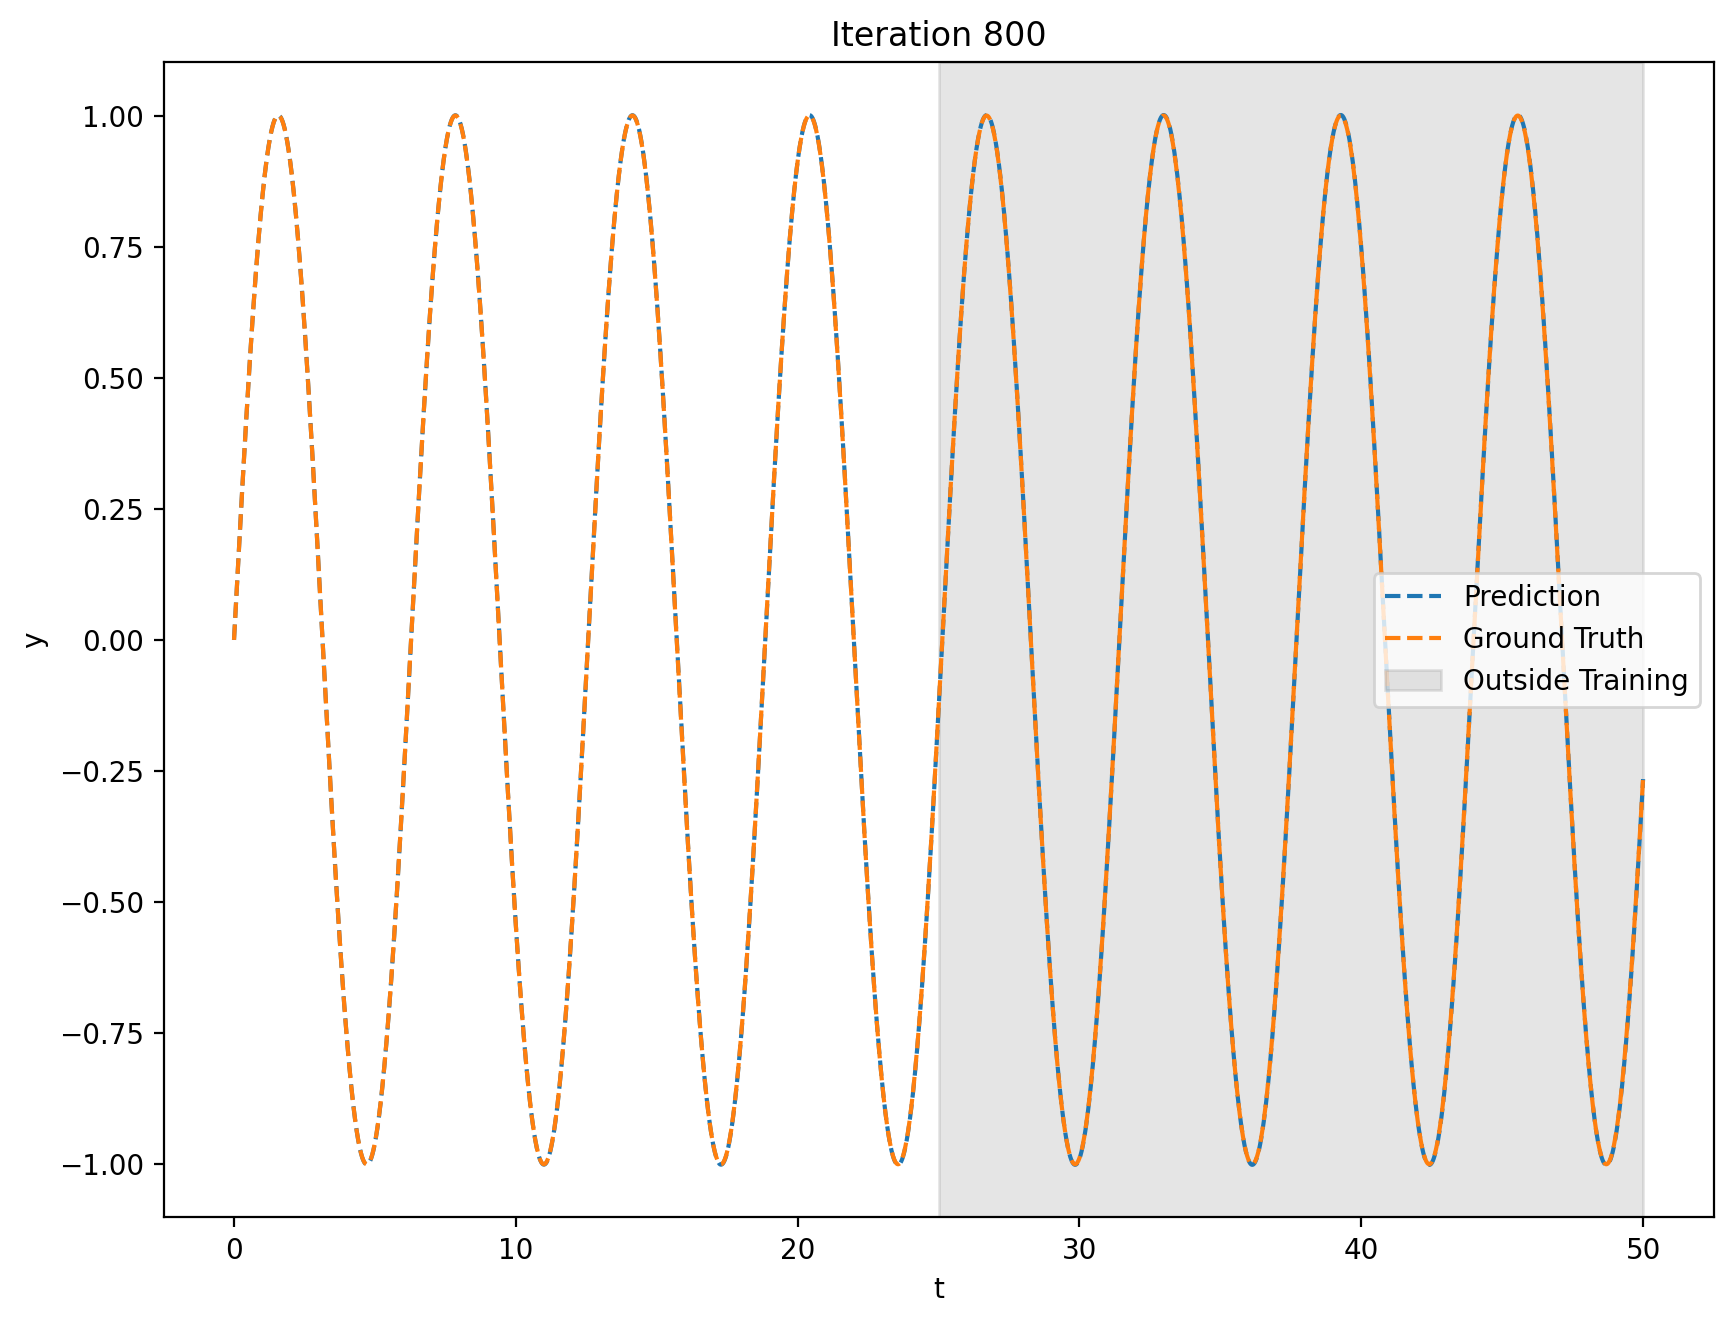

Iteration: 900 | Total Loss 0.000009


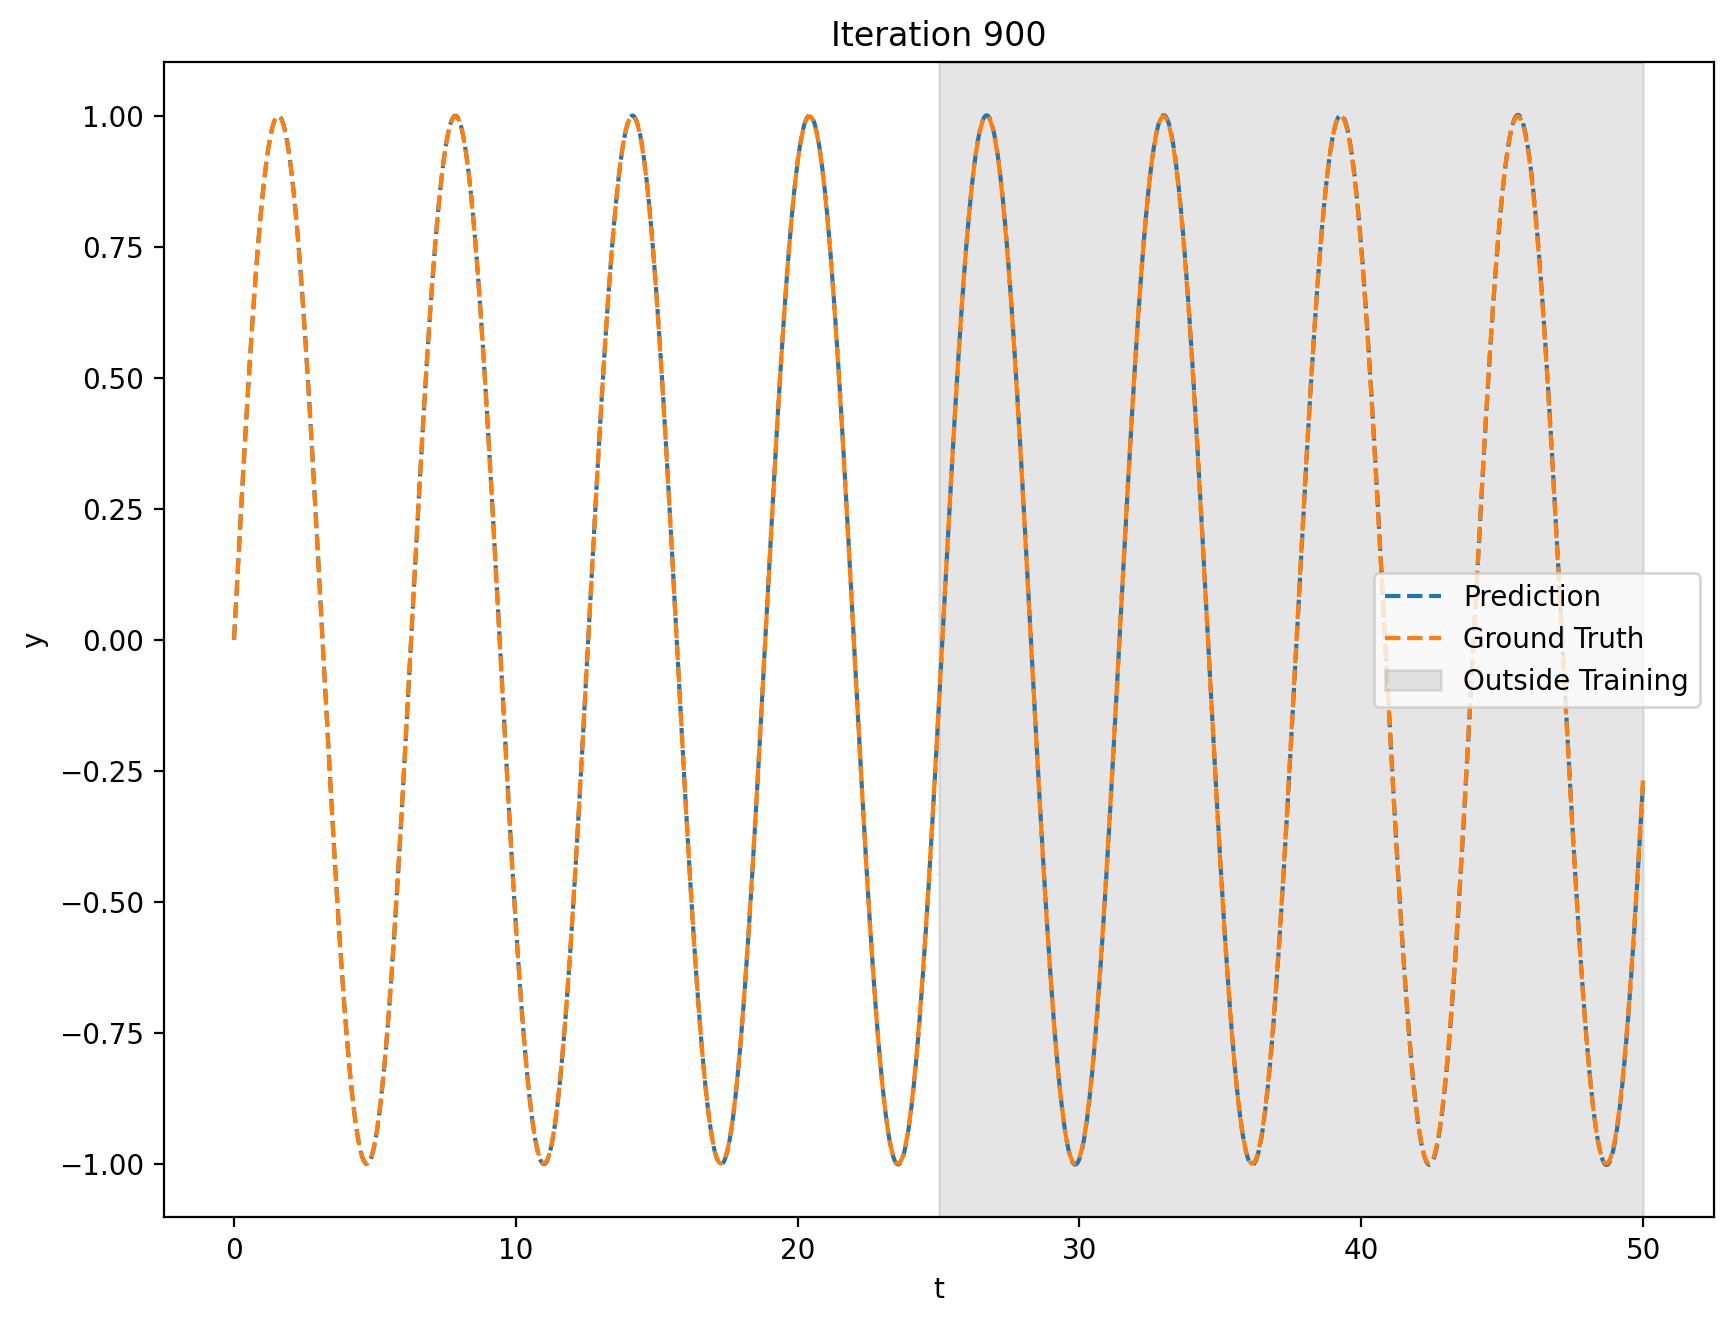

Iteration: 1000 | Total Loss 0.000003


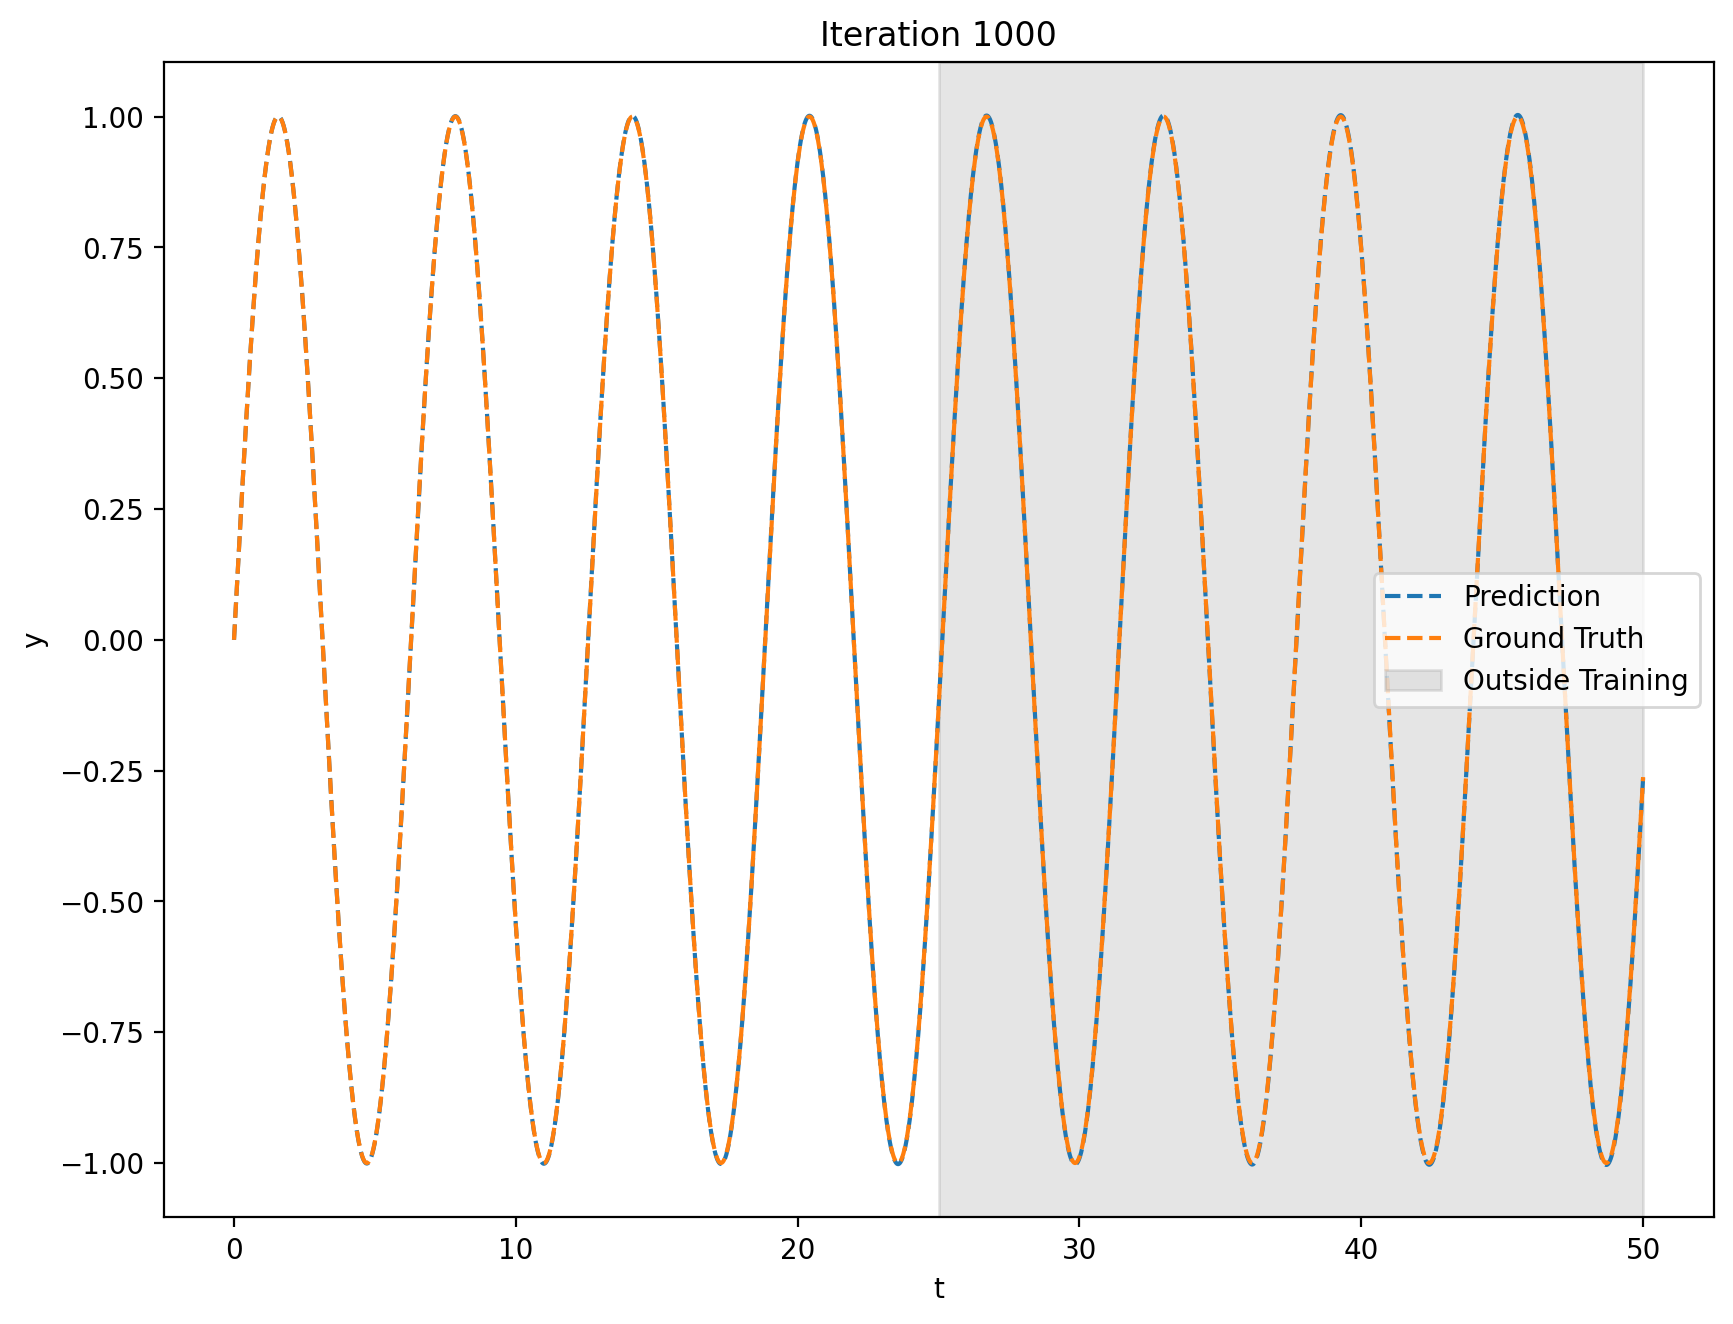

Iteration: 1100 | Total Loss 0.000011


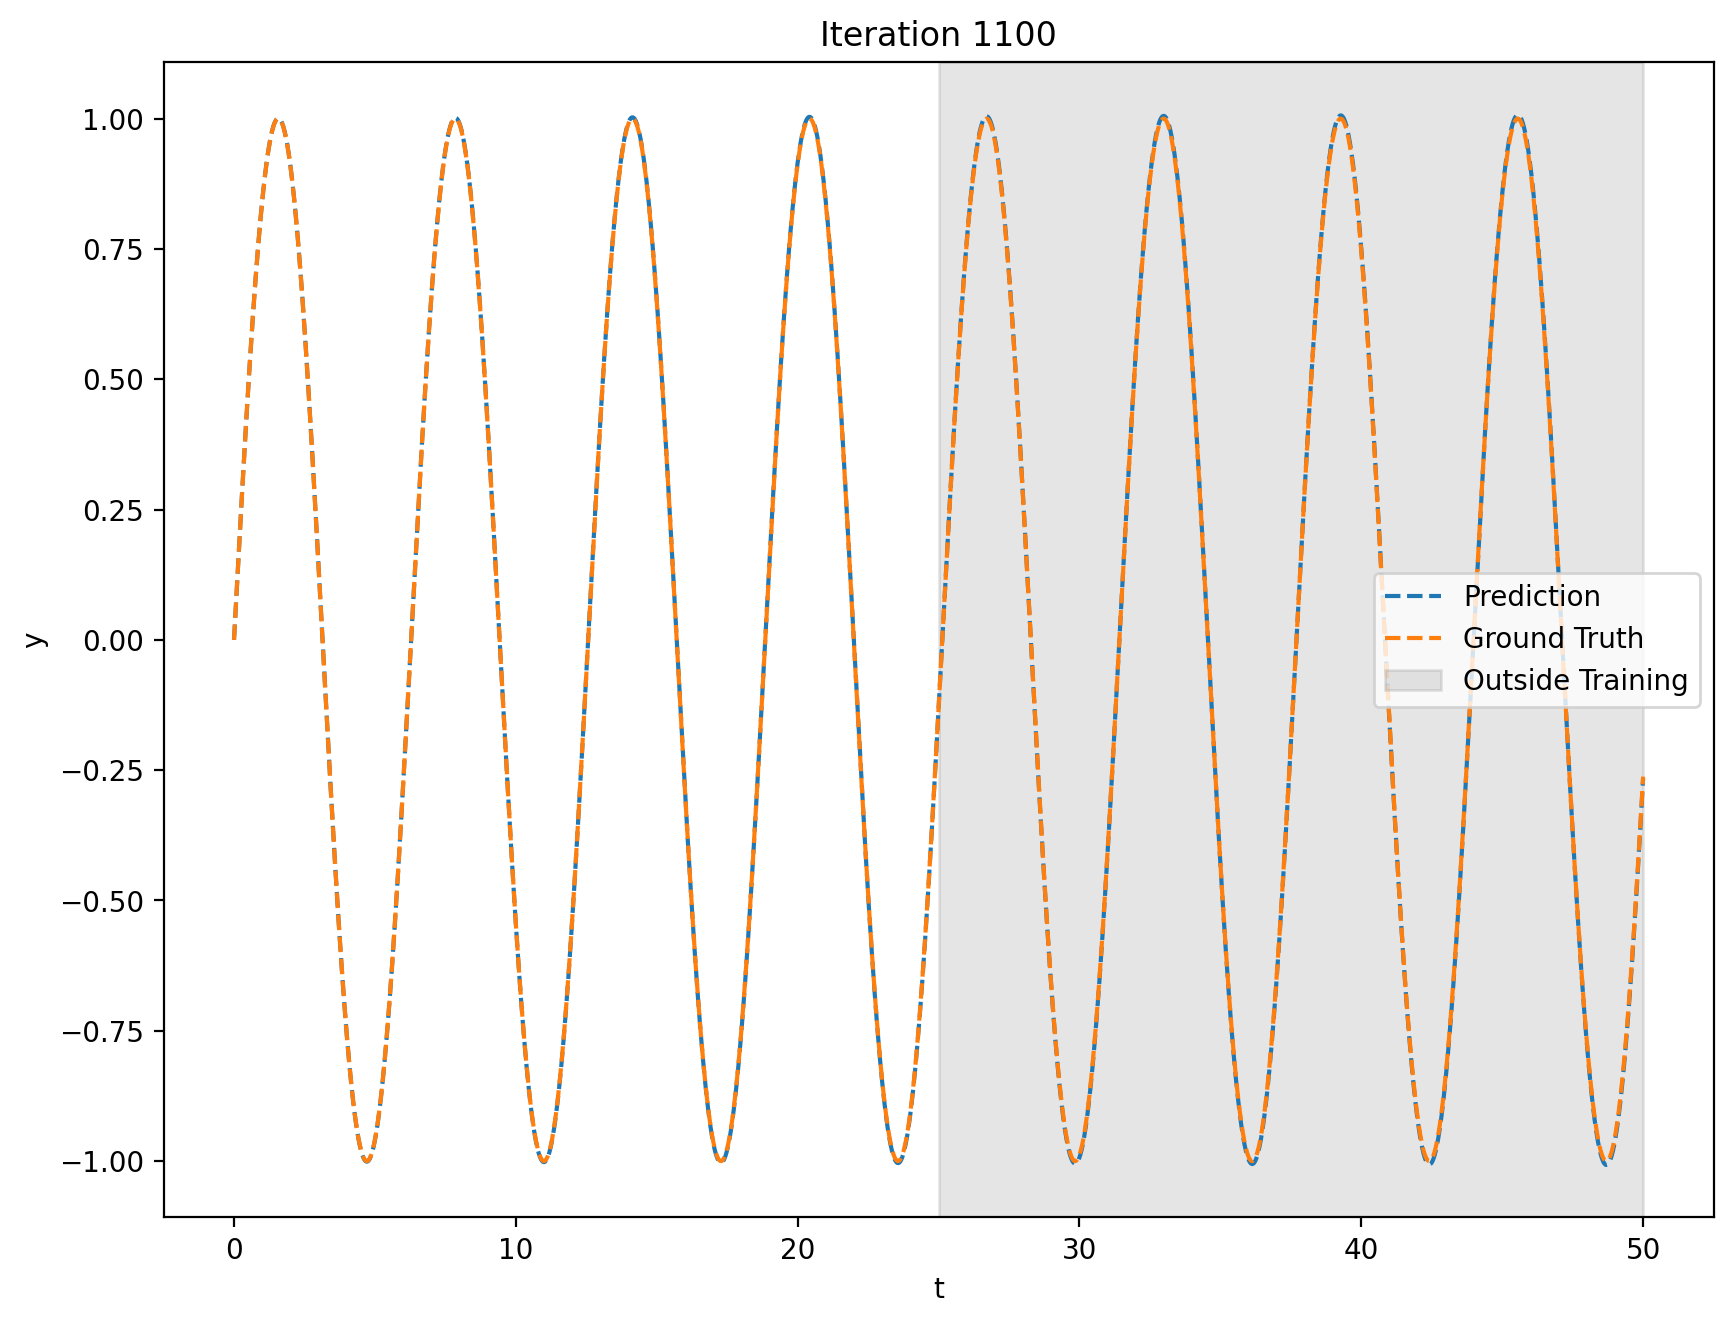

Iteration: 1200 | Total Loss 0.000002


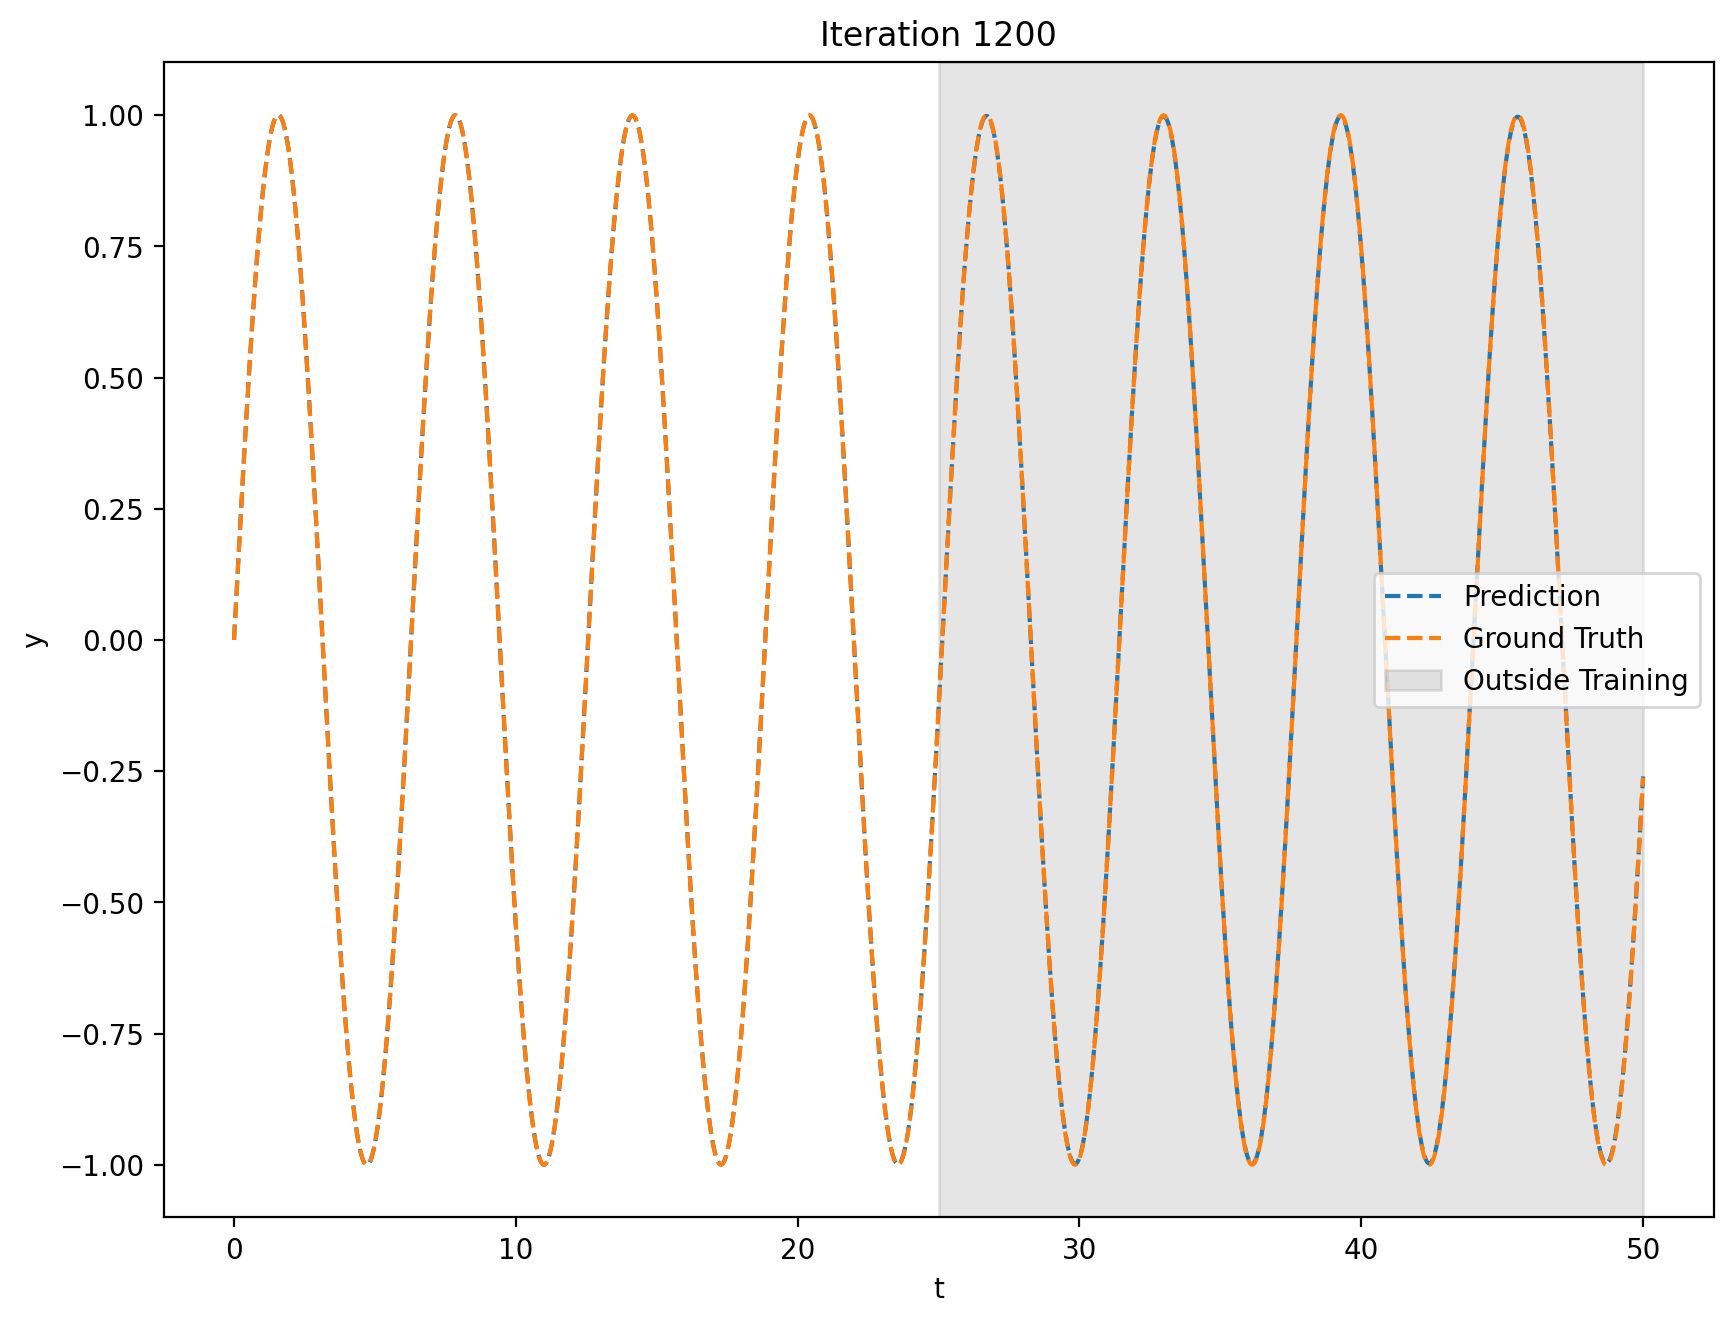

Iteration: 1300 | Total Loss 0.000011


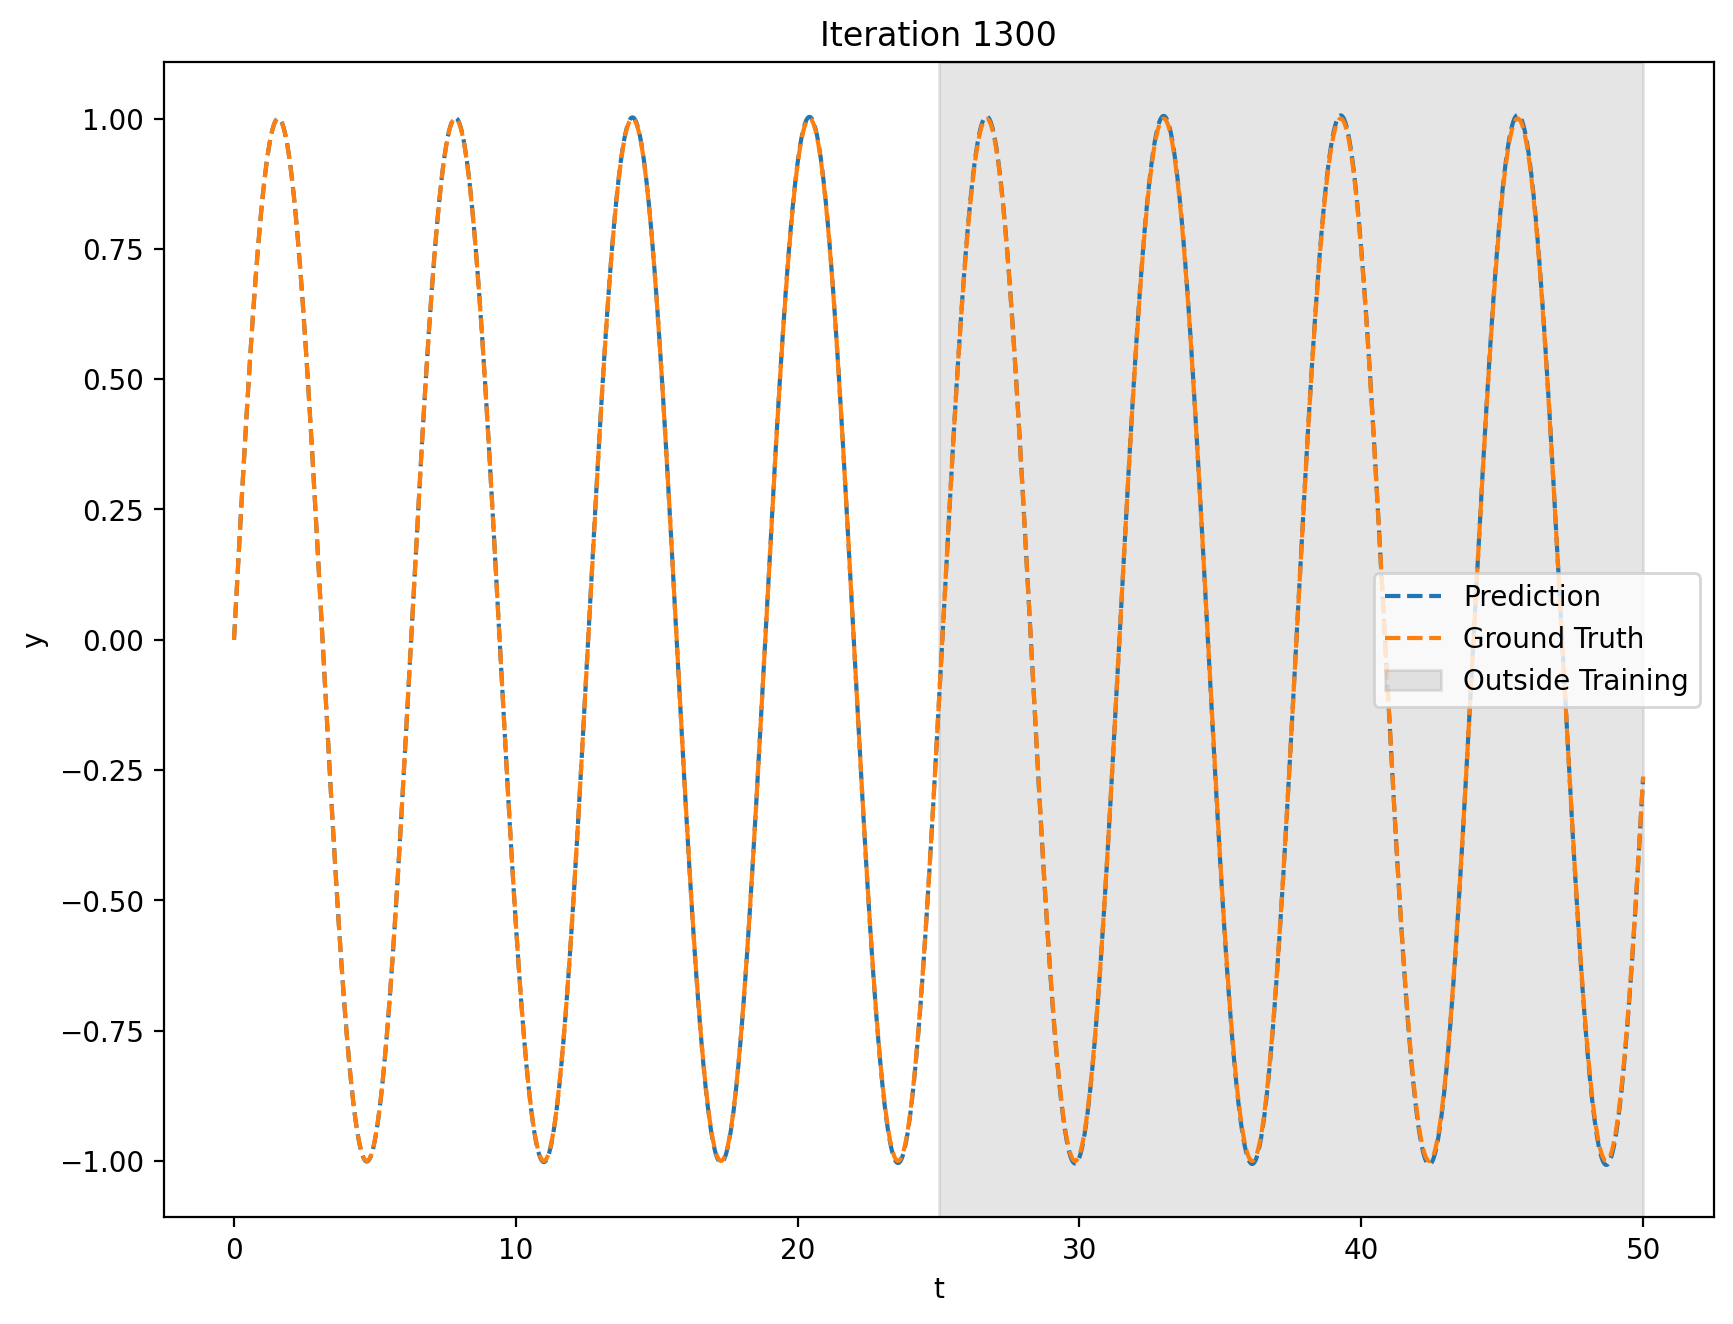

Iteration: 1400 | Total Loss 0.000011


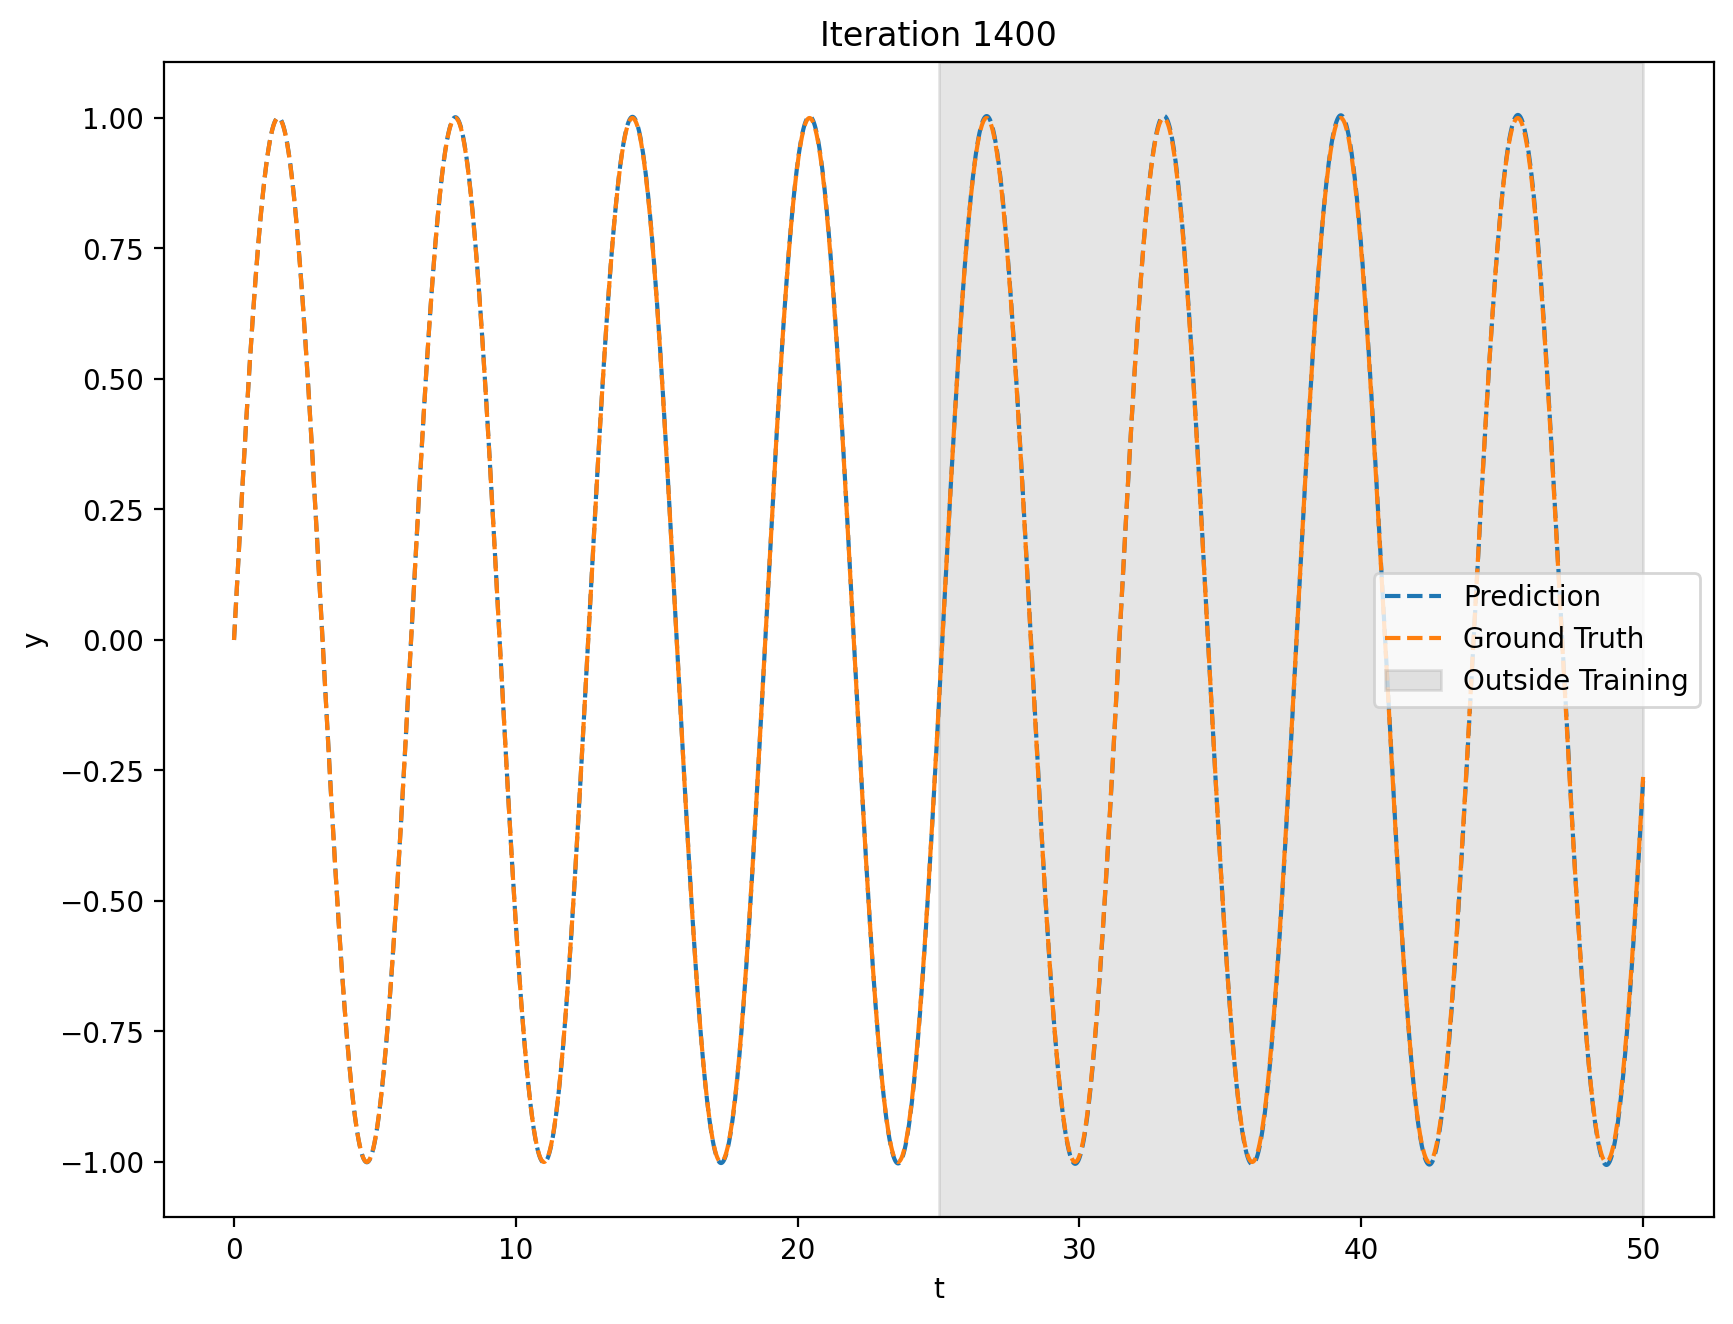

Iteration: 1500 | Total Loss 0.000021


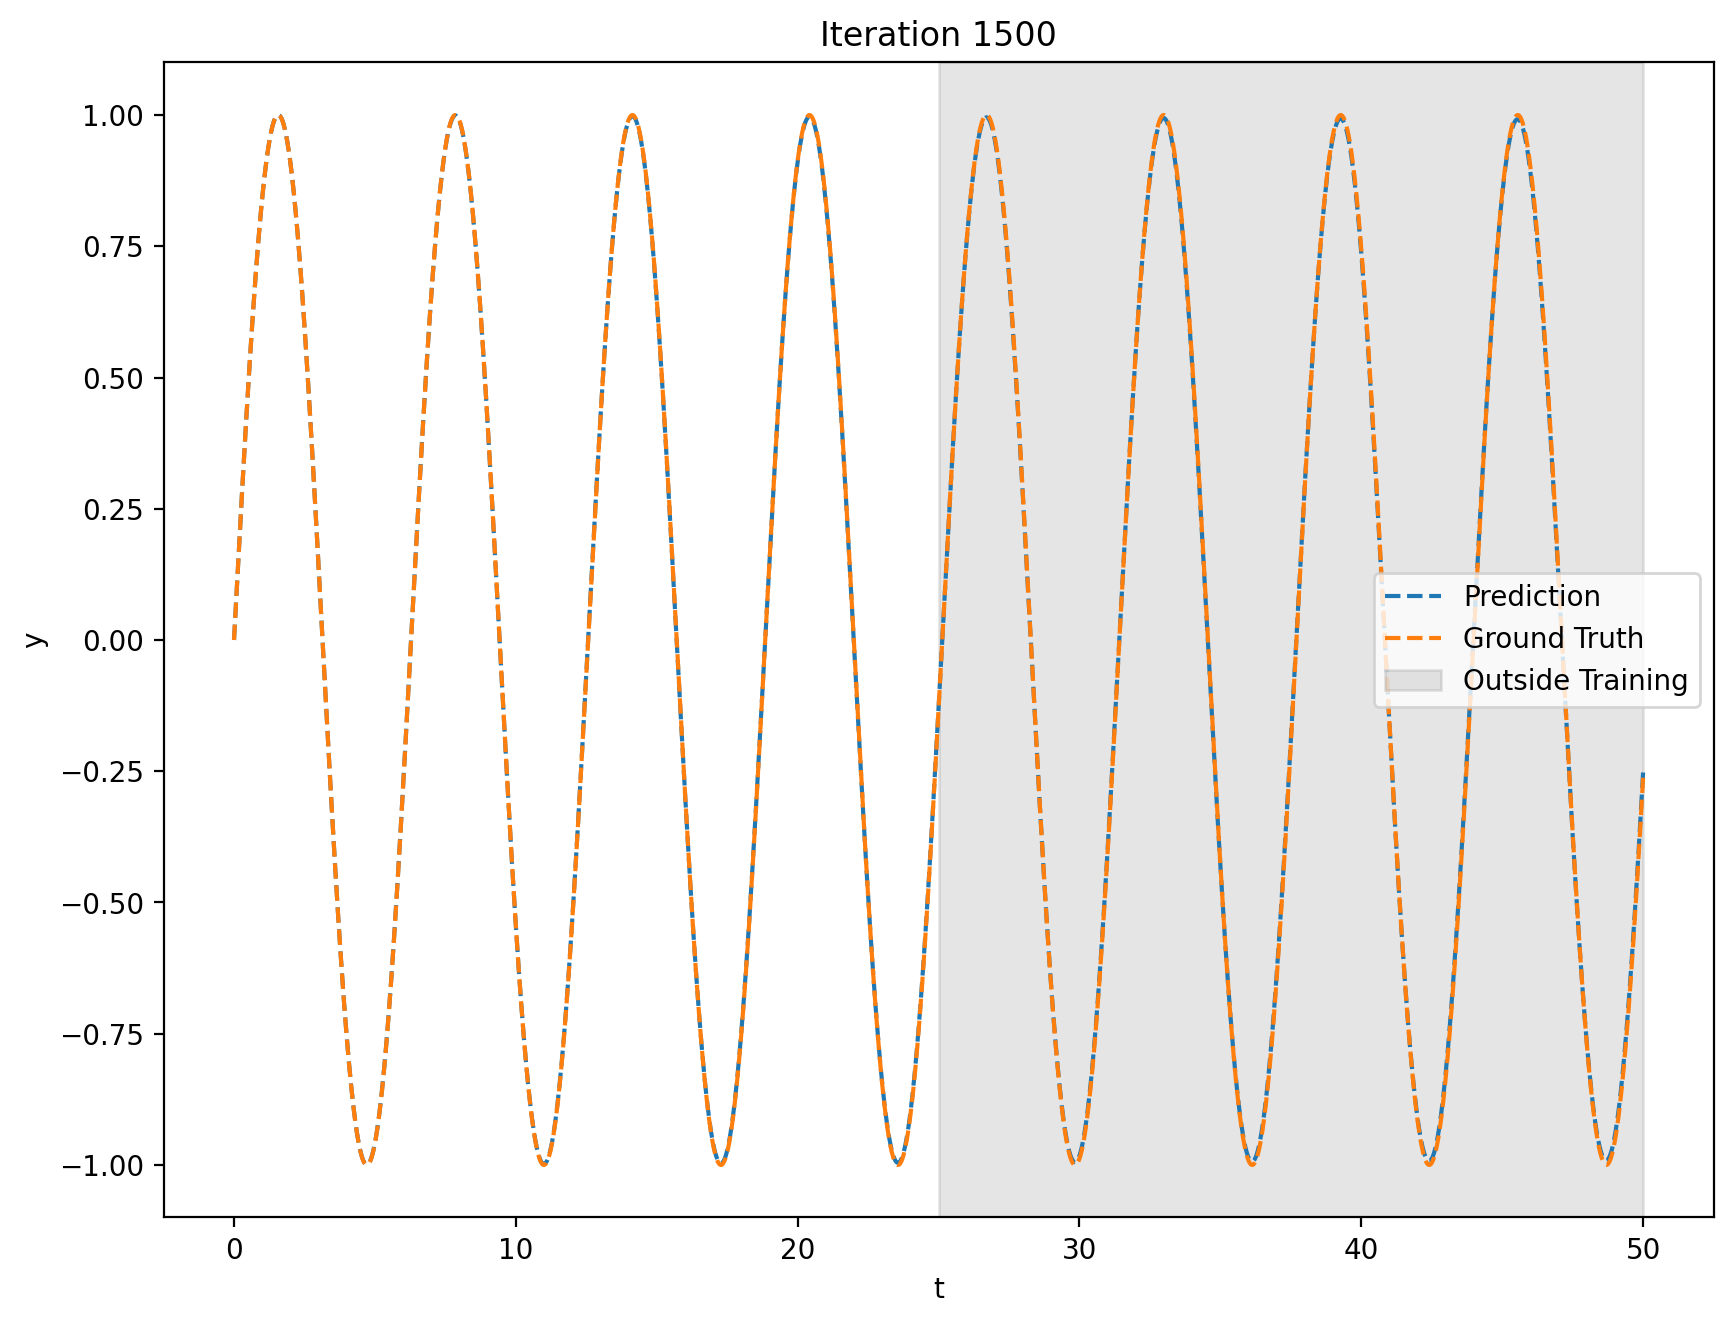

Iteration: 1600 | Total Loss 0.000001


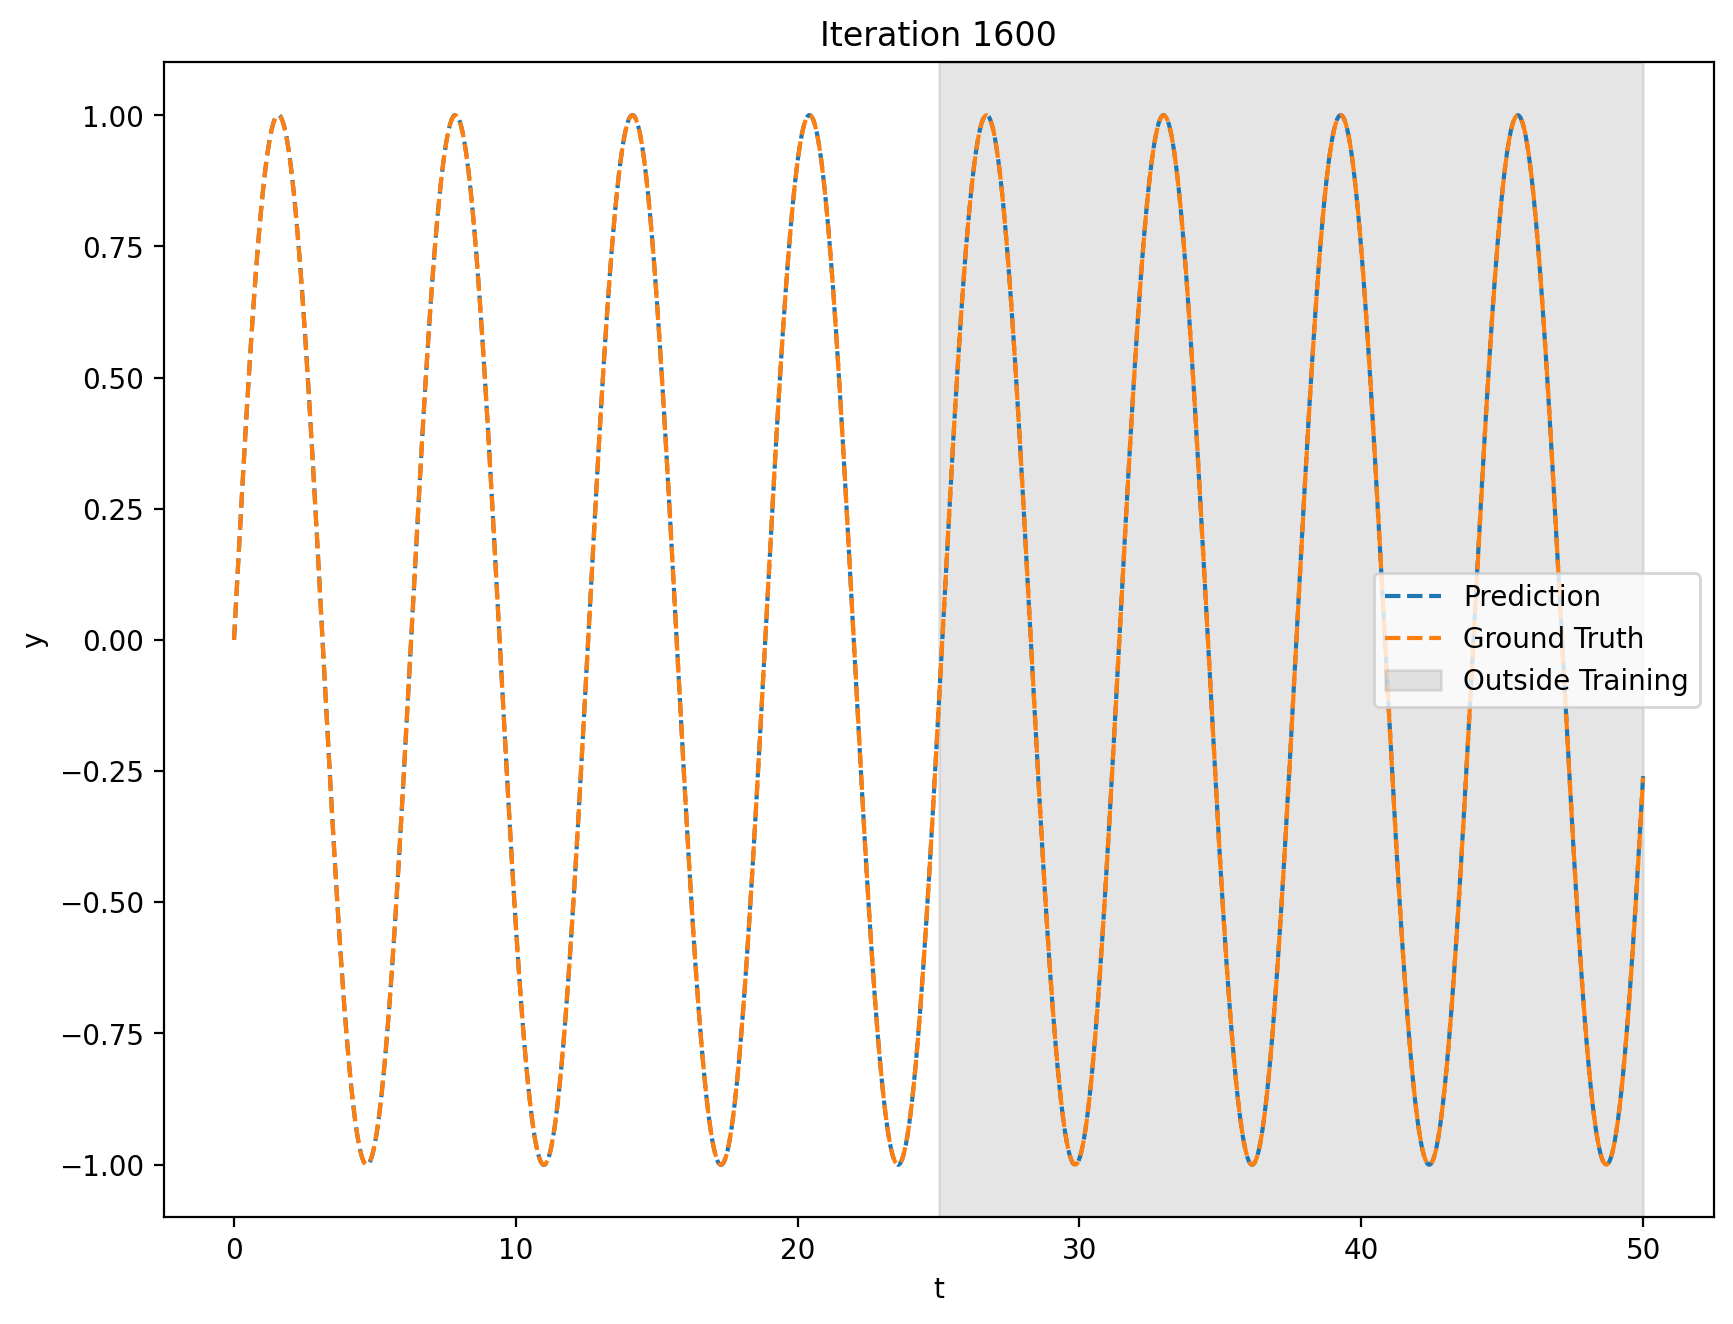

training loss reached:  8.795468353639535e-09
Iteration: 1615 | Total Loss 0.000002


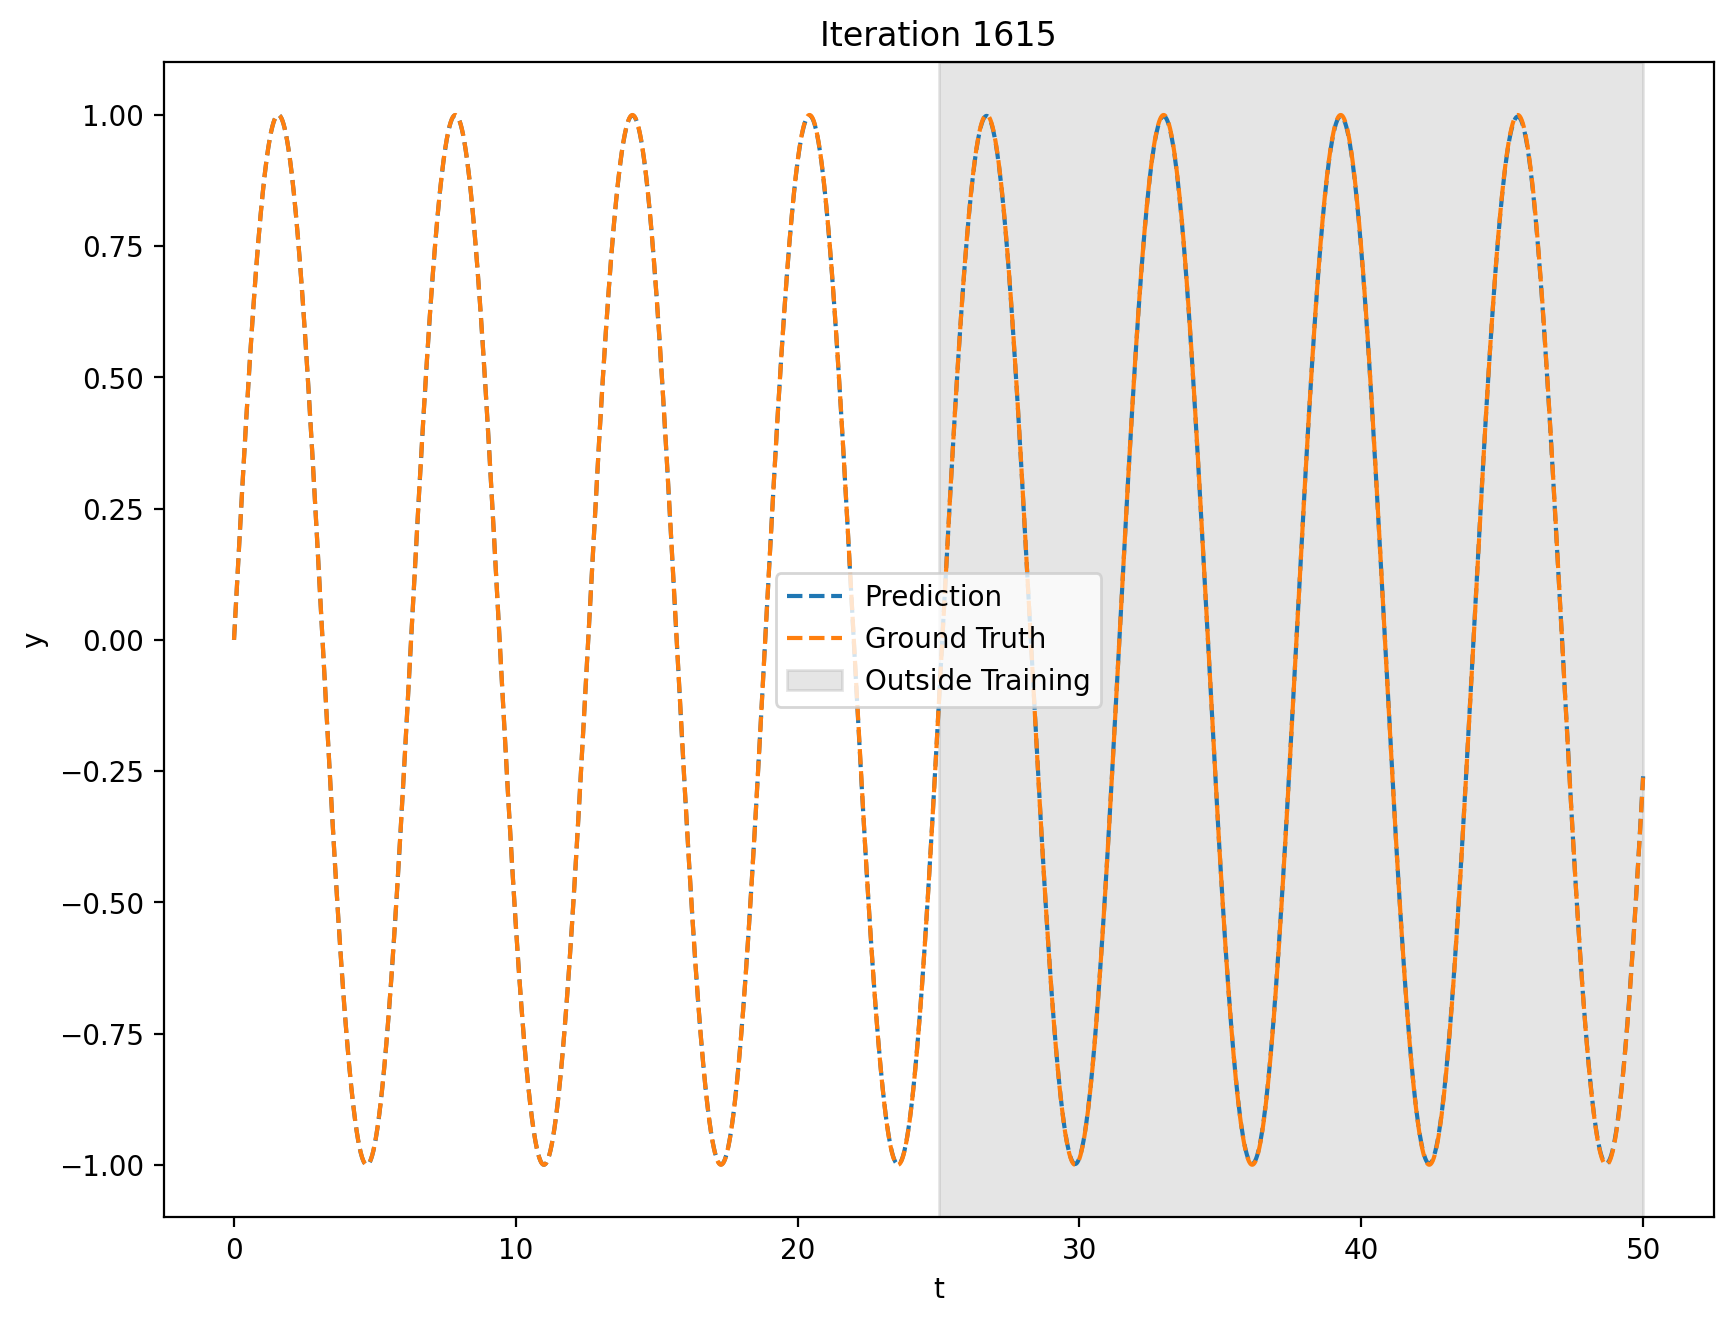

In [30]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# batch size
ts_size = 100

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')


class ODEFunc(nn.Module):
    """
    Neural Net of the ODE function
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(nn.Linear(2, 512),
                                 nn.Tanh(),
                                 nn.Linear(512, 2))

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


def get_batch():
    # randomly choosing 64 starting index in time index
    s = torch.from_numpy(np.random.choice(np.arange(size - ts_size, dtype=np.int64), 64, replace=False))
    batch_y0 = torch.Tensor(true_y[s])  # (M, D)
    batch_t = torch.Tensor(t[:ts_size])  # (T)
    batch_y = torch.Tensor(torch.stack([torch.Tensor(true_y[s + i]) for i in range(ts_size)], dim=0))  # (T, M, D)
    return batch_y0, batch_t, batch_y

ii = 0

func = ODEFunc()
optimizer = optim.AdamW(func.parameters(), lr=5e-4)
criterion = torch.nn.MSELoss()
end = time.time()

for itr in range(1, 4000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = criterion(pred_y, batch_y)
    #loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            test_t = np.linspace(0, 50, 2*size)
            pred_y = odeint(func, torch.Tensor(true_y0), torch.Tensor(test_t))
            test_true_y = scipy_odeint(ode_func, true_y0, test_t)
            target = torch.Tensor(test_true_y[:, 0])

            loss = criterion(pred_y[:, 0], target)
            pred = pred_y.detach().numpy()
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        plt.figure(figsize=(10, 7.5))
        plt.title(f"Iteration {itr}")
        plt.plot(test_t, pred_y[:, 0], c='C0', ls='--', label='Prediction')
        plt.plot(test_t, test_true_y[:, 0], c='C1', ls='--', label='Ground Truth')
        plt.axvspan(25, 50, color='gray', alpha=0.2, label='Outside Training')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(loc='best')
        plt.show()
        plt.close("all")

    if loss.item() < 0.000000009: 
        print("training loss reached: ", loss.item())
        with torch.no_grad():
            test_t = np.linspace(0, 50, 2*size)
            pred_y = odeint(func, torch.Tensor(true_y0), torch.Tensor(test_t))
            test_true_y = scipy_odeint(ode_func, true_y0, test_t)
            target = torch.Tensor(test_true_y[:, 0])

            loss = criterion(pred_y[:, 0], target)
            pred = pred_y.detach().numpy()
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        plt.figure(figsize=(10, 7.5))
        plt.title(f"Iteration {itr}")
        plt.plot(test_t, pred_y[:, 0], c='C0', ls='--', label='Prediction')
        plt.plot(test_t, test_true_y[:, 0], c='C1', ls='--', label='Ground Truth')
        plt.axvspan(25, 50, color='gray', alpha=0.2, label='Outside Training')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(loc='best')
        plt.show()
        plt.close("all")
        break # early stopping if loss target is met 2e-8

    end = time.time()